## Import dependancies

In [1]:
import os
import csv
import datetime
from datetime import date, timedelta

import pandas as pd
import numpy as np

# for Visualization
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

# Tensorflow and keras for DL models
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# SciKitLearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier

# for ARIMA model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

from xgboost import XGBClassifier



In [2]:
import math

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle


def plot_colortable(colors, *, ncols=4, sort_colors=True):

    cell_width = 212
    cell_height = 22
    swatch_width = 48
    margin = 12

    # Sort colors by hue, saturation, value and name.
    if sort_colors is True:
        names = sorted(
            colors, key=lambda c: tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(c))))
    else:
        names = list(colors)

    n = len(names)
    nrows = math.ceil(n / ncols)

    width = cell_width * ncols + 2 * margin
    height = cell_height * nrows + 2 * margin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-margin)/height)
    ax.set_xlim(0, cell_width * ncols)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.add_patch(
            Rectangle(xy=(swatch_start_x, y-9), width=swatch_width,
                      height=18, facecolor=colors[name], edgecolor='0.7')
        )

    return fig

## Model Training

### Load the data and visualize

In [3]:
# Load the csv data
dff = pd.read_csv('../clean_data/finalv2.csv')

# Set the Datetime column to dataframe index
dff['DATETIME'] = pd.to_datetime(dff['DATETIME'])
dff.set_index('DATETIME', inplace=True)

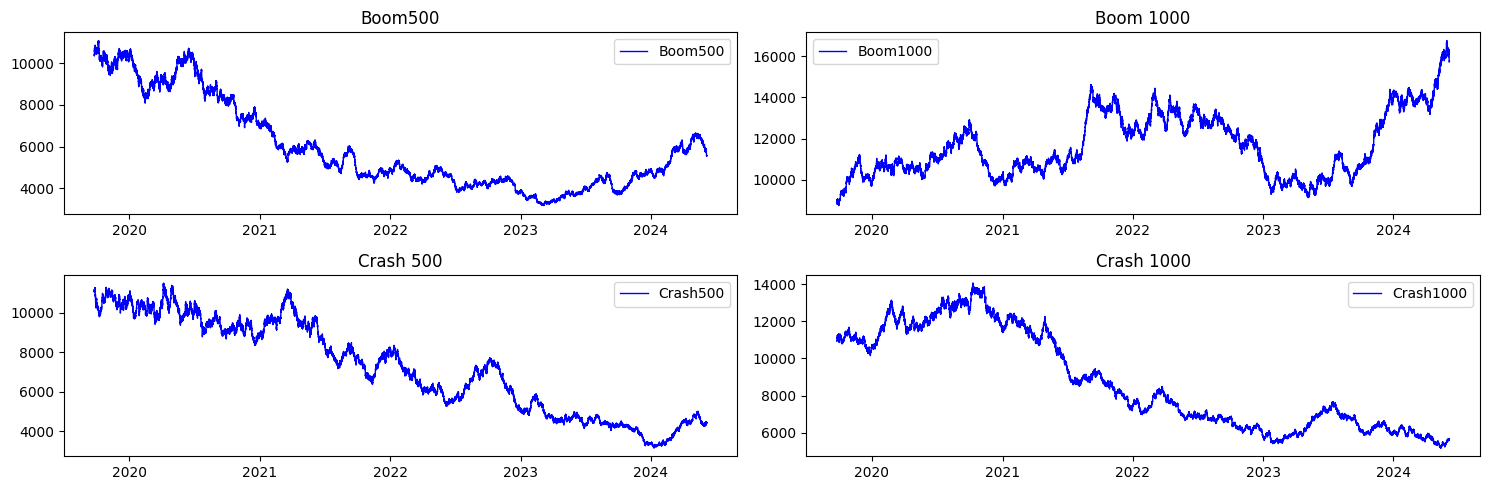

In [18]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 5))


axs[0,0].plot(dff.index, dff['OPEN_Boom_500_1h'], label='Boom500', color='blue', linewidth = 1)
axs[0,0].set_title('Boom500')
axs[0,0].legend()

axs[0,1].plot(dff.index, dff['OPEN_Boom_1000_1h'], label='Boom1000', color='blue', linewidth = 1)
axs[0,1].set_title('Boom 1000')
axs[0,1].legend()

axs[1,0].plot(dff.index, dff['OPEN_Crash_500_1h'], label='Crash500', color='blue', linewidth = 1)
axs[1,0].set_title('Crash 500')
axs[1,0].legend()

axs[1,1].plot(dff.index, dff['OPEN_Crash_1000_1h'], label='Crash1000', color='blue', linewidth = 1)
axs[1,1].set_title('Crash 1000')
axs[1,1].legend()


plt.tight_layout()
plt.show()

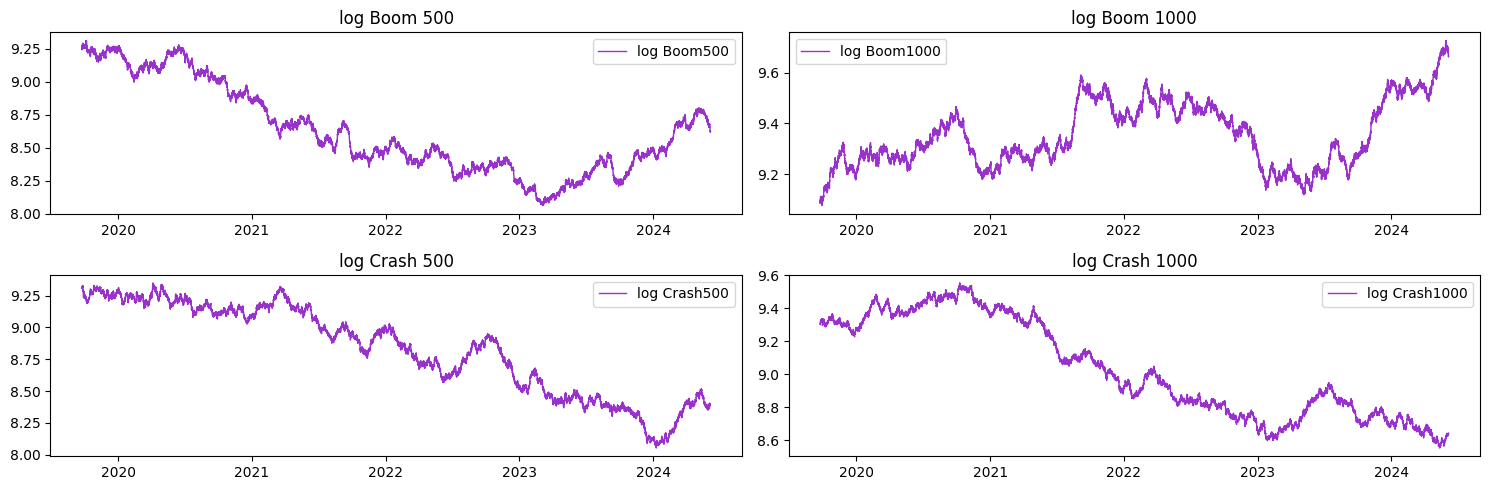

In [19]:
# Create subplots for log charts
fig, axs = plt.subplots(2, 2, figsize=(15, 5))


axs[0,0].plot(dff.index, np.log(dff['OPEN_Boom_500_1h']), label='log Boom500', color='darkorchid', linewidth = 1)
axs[0,0].set_title('log Boom 500')
axs[0,0].legend()

axs[0,1].plot(dff.index, np.log(dff['OPEN_Boom_1000_1h']), label='log Boom1000', color='darkorchid', linewidth = 1)
axs[0,1].set_title('log Boom 1000')
axs[0,1].legend()

axs[1,0].plot(dff.index, np.log(dff['OPEN_Crash_500_1h']), label='log Crash500', color='darkorchid', linewidth = 1)
axs[1,0].set_title('log Crash 500')
axs[1,0].legend()

axs[1,1].plot(dff.index, np.log(dff['OPEN_Crash_1000_1h']), label='log Crash1000', color='darkorchid', linewidth = 1)
axs[1,1].set_title('log Crash 1000')
axs[1,1].legend()


plt.tight_layout()
plt.show()

## DNN

In [4]:
# Load the csv data
dff = pd.read_csv('../clean_data/finalv2.csv')

# Set the Datetime column to dataframe index
dff['DATETIME'] = pd.to_datetime(dff['DATETIME'])

In [5]:
dff.tail(2)

DATETIME  OPEN_Boom_500_1h  HIGH_Boom_500_1h  \
41183 2024-06-05 12:00:00          5571.791          5584.975   
41184 2024-06-05 13:00:00          5572.613          5577.513   

       LOW_Boom_500_1h  CLOSE_Boom_500_1h  TICKVOL_Boom_500_1h  \
41183         5562.126           5572.614               3501.0   
41184         5560.821           5560.821               3507.0   

       SPREAD_Boom_500_1h  OPEN_Boom_1000_1h  HIGH_Boom_1000_1h  \
41183                77.0          15772.149          15786.650   
41184                77.0          15775.712          15777.547   

       LOW_Boom_1000_1h  ...  TICKVOL_v100_1s_1h  SPREAD_v100_1s_1h  \
41183         15761.744  ...              3498.0               23.0   
41184         15744.566  ...              3501.0               23.0   

       b500_pred  b1000_pred  c500_pred  c1000_pred  b500d  b1000d  c500d  \
41183   5554.248   15749.478   4391.652    5629.893      0       0      0   
41184   5547.663   15729.533   4387.600    5621.148      0       0      0   

       c1000d  
41183       0  
41184       1  

[2 rows x 69 columns]

In [6]:
dff.head(5)

DATETIME  OPEN_Boom_500_1h  HIGH_Boom_500_1h  LOW_Boom_500_1h  \
0 2019-09-24 10:00:00         10400.494         10424.152        10371.779   
1 2019-09-24 11:00:00         10384.307         10396.974        10373.027   
2 2019-09-24 12:00:00         10392.802         10419.518        10374.519   
3 2019-09-24 13:00:00         10394.055         10394.055        10362.002   
4 2019-09-24 14:00:00         10378.005         10389.885        10360.337   

   CLOSE_Boom_500_1h  TICKVOL_Boom_500_1h  SPREAD_Boom_500_1h  \
0          10384.335               3541.0               145.0   
1          10392.823               3549.0               145.0   
2          10394.087               3550.0               145.0   
3          10378.042               3555.0               145.0   
4          10379.920               3557.0               145.0   

   OPEN_Boom_1000_1h  HIGH_Boom_1000_1h  LOW_Boom_1000_1h  ...  \
0           8900.178           8907.848          8890.862  ...   
1           8896.197           8907.447          8885.272  ...   
2           8902.507           8910.977          8887.479  ...   
3           8887.475           8887.475          8860.266  ...   
4           8860.260           8860.260          8841.002  ...   

   TICKVOL_v100_1s_1h  SPREAD_v100_1s_1h  b500_pred  b1000_pred  c500_pred  \
0              2514.0              100.0  10394.087    8887.479  11106.491   
1              3593.0              100.0  10378.042    8860.266  11148.710   
2              3592.0              100.0  10379.920    8856.861  11162.341   
3              3593.0               45.0  10429.627    8865.074  11132.328   
4              3594.0              500.0  10455.674    8857.392  11127.879   

   c1000_pred  b500d  b1000d  c500d  c1000d  
0   10942.681      0       0      0       1  
1   10950.269      0       0      0       0  
2   10933.714      0       0      0       1  
3   10965.770      1       0      0       0  
4   10951.992      1       0      1       0  

[5 rows x 69 columns]

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [75]:
X = dff.drop(columns=['DATETIME','b500_pred','b1000_pred','c500_pred','c1000_pred','b500d','b1000d','c500d','c1000d']).values
y = dff['b500d'].values



In [78]:
X[1].shape

(60,)

In [72]:
y[0:10]

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 1], dtype=int64)

### Using standard scaler

In [79]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [80]:
X_train[0]

array([-0.06411058, -0.05440493, -0.05785909, -0.0495756 ,  0.02902366,
       -0.04700878, -0.75896558, -0.76891962, -0.75990739, -0.77049148,
       -0.10482259, -0.78216104,  1.34743522,  1.35043465,  1.35418308,
        1.34718782,  0.6203879 ,  1.34452026,  0.7858817 ,  0.7874056 ,
        0.78742531,  0.79122077,  0.45726821,  0.77000763, -1.40896565,
       -1.41577463, -1.41896445, -1.42897899,  0.1256766 , -0.4001931 ,
        0.23020867,  0.2588648 ,  0.24792149,  0.2772843 , -0.30118063,
        0.0492577 , -1.94196624, -1.95285085, -1.95477223, -1.94853356,
        0.02209967, -0.90601216,  1.02845899,  1.01586677,  1.03559649,
        1.01739722,  0.04140409,  0.39572652, -0.42692423, -0.42091727,
       -0.4222956 , -0.4202864 ,  0.0949882 , -0.44174589,  0.10383359,
        0.09596145,  0.09885751,  0.09222124,  0.45394595, -0.05594135])

In [81]:
y_train[:10]

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 1], dtype=int64)

In [35]:
'''
# Define the model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  #sigmoid activation for binary classification
'''

model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.LeakyReLU(negative_slope=0.1),
    layers.Dense(128, activation='relu'),
    layers.LeakyReLU(negative_slope=0.1),
    layers.Dense(64, activation='relu'),
    layers.LeakyReLU(negative_slope=0.1),
    layers.Dense(32, activation='relu'),
    layers.LeakyReLU(negative_slope=0.1),
    layers.Dense(16, activation='relu'),
    layers.LeakyReLU(negative_slope=0.1),
    layers.Dense(8, activation='relu'),
    layers.LeakyReLU(negative_slope=0.1),
    layers.Dense(1, activation='sigmoid')])


In [36]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [37]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=10, validation_split=0.2, verbose=1)


Epoch 1/20
2636/2636 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7531 - loss: 0.5570 - val_accuracy: 0.7589 - val_loss: 0.5470
Epoch 2/20
2636/2636 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7614 - loss: 0.5428 - val_accuracy: 0.7589 - val_loss: 0.5494
Epoch 3/20
2636/2636 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7574 - loss: 0.5458 - val_accuracy: 0.7589 - val_loss: 0.5468
Epoch 4/20
2636/2636 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7642 - loss: 0.5367 - val_accuracy: 0.7589 - val_loss: 0.5480
Epoch 5/20
2636/2636 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7551 - loss: 0.5461 - val_accuracy: 0.7589 - val_loss: 0.5474
Epoch 6/20
2636/2636 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7585 - loss: 0.5437 - val_accuracy: 0.7589 - val_loss: 0.5456
Epoch 7/20
2636/2636 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7599 - loss: 0.5437 - val_accuracy: 0.7589 - val_loss: 0.5457
Epoch 8/20
2636/2636 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7600 - loss: 0.5408 -

In [ ]:
#del(history)

Accuracy on test data: 0.7546436786651611


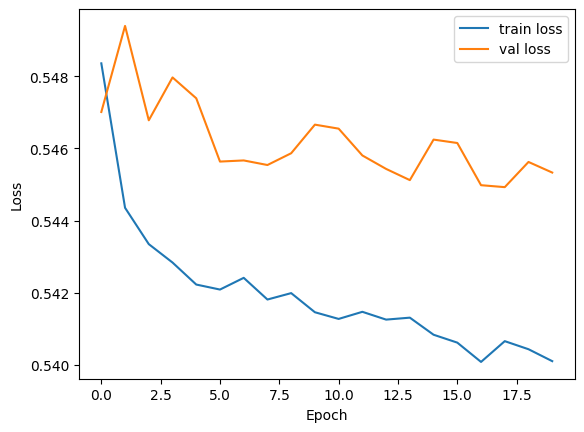

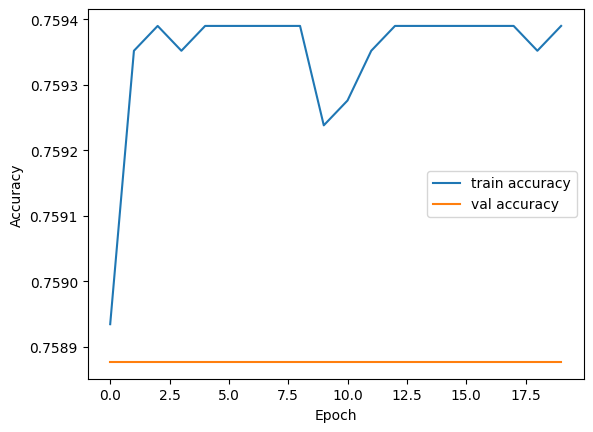

In [41]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Accuracy on test data: {accuracy}')

# Plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


### Without Scaling

In [146]:
X = dff.drop(columns=['DATETIME','b500_pred','b1000_pred','c500_pred','c1000_pred','b500d','b1000d','c500d','c1000d']).values
X_cols = dff.drop(columns=['DATETIME','b500_pred','b1000_pred','c500_pred','c1000_pred','b500d','b1000d','c500d','c1000d'])
y = dff['b500d'].values

In [147]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [148]:
X_train

array([[ 5797.071,  5831.205,  5796.966, ...,  5353.22 ,  3590.   ,
          140.   ],
       [ 4623.308,  4623.308,  4612.039, ...,  3487.88 ,  3579.   ,
           84.   ],
       [ 5888.27 ,  5891.961,  5866.887, ...,  5160.94 ,  3585.   ,
          146.   ],
       ...,
       [ 4951.206,  4980.724,  4948.041, ...,  1633.98 ,  3548.   ,
           41.   ],
       [10151.85 , 10152.013, 10097.61 , ...,  8746.78 ,  3592.   ,
          500.   ],
       [ 5083.681,  5090.901,  5074.786, ...,  4946.01 ,  3581.   ,
          133.   ]])

In [52]:
model2 = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(256, activation='linear'),
    layers.LeakyReLU(negative_slope=0.1),
    layers.Dense(128, activation='linear'),
    layers.LeakyReLU(negative_slope=0.1),
    layers.Dense(64, activation='linear'),
    layers.LeakyReLU(negative_slope=0.1),
    layers.Dense(32, activation='linear'),
    layers.LeakyReLU(negative_slope=0.1),
    layers.Dense(16, activation='linear'),
    layers.LeakyReLU(negative_slope=0.1),
    layers.Dense(8, activation='linear'),
    layers.LeakyReLU(negative_slope=0.1),
    layers.Dense(1, activation='sigmoid')])

In [53]:
# Compile the model
model2.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [54]:
# Train the model
history2 = model2.fit(X_train, y_train, epochs=20, batch_size=8, validation_split=0.2, verbose=1)

Epoch 1/20
3295/3295 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.6416 - loss: 60.6089 - val_accuracy: 0.5827 - val_loss: 2.1029
Epoch 2/20
3295/3295 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.6407 - loss: 8.9754 - val_accuracy: 0.7587 - val_loss: 2.1513
Epoch 3/20
3295/3295 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.6463 - loss: 5.3043 - val_accuracy: 0.3244 - val_loss: 2.1827
Epoch 4/20
3295/3295 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.6485 - loss: 3.1155 - val_accuracy: 0.2414 - val_loss: 3.1678
Epoch 5/20
3295/3295 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.6353 - loss: 6.8654 - val_accuracy: 0.7589 - val_loss: 3.5561
Epoch 6/20
3295/3295 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.6411 - loss: 2.3129 - val_accuracy: 0.6822 - val_loss: 9.1693
Epoch 7/20
3295/3295 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.6442 - loss: 9.5096 - val_accuracy: 0.2686 - val_loss: 1.8996
Epoch 8/20
3295/3295 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.6506 - loss: 1.7857

In [ ]:
del(history2)

In [51]:
del(model2)

### Regression

In [8]:
dff.tail(2)

DATETIME  OPEN_Boom_500_1h  HIGH_Boom_500_1h  \
41183 2024-06-05 12:00:00          5571.791          5584.975   
41184 2024-06-05 13:00:00          5572.613          5577.513   

       LOW_Boom_500_1h  CLOSE_Boom_500_1h  TICKVOL_Boom_500_1h  \
41183         5562.126           5572.614               3501.0   
41184         5560.821           5560.821               3507.0   

       SPREAD_Boom_500_1h  OPEN_Boom_1000_1h  HIGH_Boom_1000_1h  \
41183                77.0          15772.149          15786.650   
41184                77.0          15775.712          15777.547   

       LOW_Boom_1000_1h  ...  TICKVOL_v100_1s_1h  SPREAD_v100_1s_1h  \
41183         15761.744  ...              3498.0               23.0   
41184         15744.566  ...              3501.0               23.0   

       b500_pred  b1000_pred  c500_pred  c1000_pred  b500d  b1000d  c500d  \
41183   5554.248   15749.478   4391.652    5629.893      0       0      0   
41184   5547.663   15729.533   4387.600    5621.148      0       0      0   

       c1000d  
41183       0  
41184       1  

[2 rows x 69 columns]

In [11]:
X = dff.drop(columns=['DATETIME','b500_pred','b1000_pred','c500_pred','c1000_pred','b500d','b1000d','c500d','c1000d']).values
y = dff['b500_pred'].values

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

In [13]:
from tensorflow.keras.layers import Input, Dense, Dropout

In [14]:
# Define the model
model3 = Sequential()
model3.add(Input(shape=(X_train.shape[1],)))
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(1, activation='linear'))

In [15]:
# Compile the model
model3.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mean_absolute_error'])


In [16]:
# Train the model
history3 = model3.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2, verbose=1)


Epoch 1/20
1648/1648 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 947638272.0000 - mean_absolute_error: 19457.7598 - val_loss: 11066311.0000 - val_mean_absolute_error: 2441.3193
Epoch 2/20
1648/1648 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 49900108.0000 - mean_absolute_error: 5350.6118 - val_loss: 11072829.0000 - val_mean_absolute_error: 2433.5396
Epoch 3/20
1648/1648 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 24396364.0000 - mean_absolute_error: 3832.2102 - val_loss: 10840679.0000 - val_mean_absolute_error: 2460.2573
Epoch 4/20
1648/1648 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 15661786.0000 - mean_absolute_error: 3088.0791 - val_loss: 5563009.5000 - val_mean_absolute_error: 1940.6425
Epoch 5/20
1648/1648 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 8525810.0000 - mean_absolute_error: 2242.0339 - val_loss: 2779078.2500 - val_mean_absolute_error: 1489.0624
Epoch 6/20
1648/1648 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 5063510.5000 - mean_absolute_error: 1722.0042 - val_loss: 2674322.7500 - val_me

Mean Absolute Error on test data: 1946.044189453125


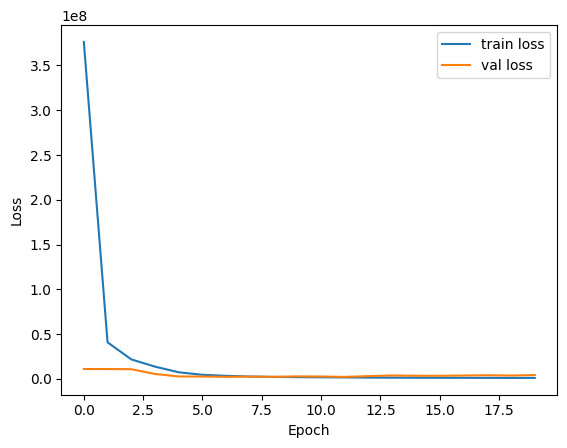

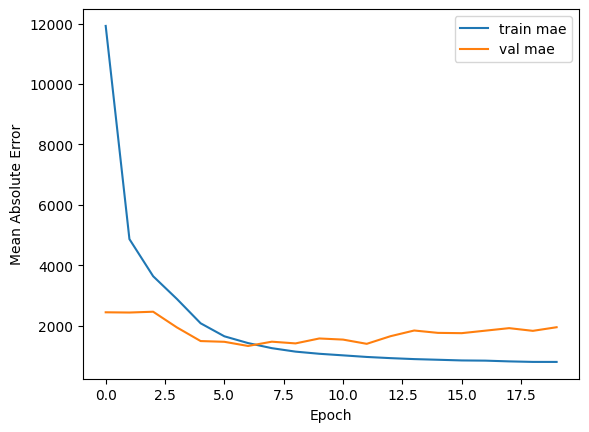

In [17]:
# Evaluate the model
loss, mae = model3.evaluate(X_test, y_test, verbose=0)
print(f'Mean Absolute Error on test data: {mae}')

# Plot training history
import matplotlib.pyplot as plt

plt.plot(history3.history['loss'], label='train loss')
plt.plot(history3.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history3.history['mean_absolute_error'], label='train mae')
plt.plot(history3.history['val_mean_absolute_error'], label='val mae')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()


In [19]:
y_preds = model3.predict(X_test)

258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


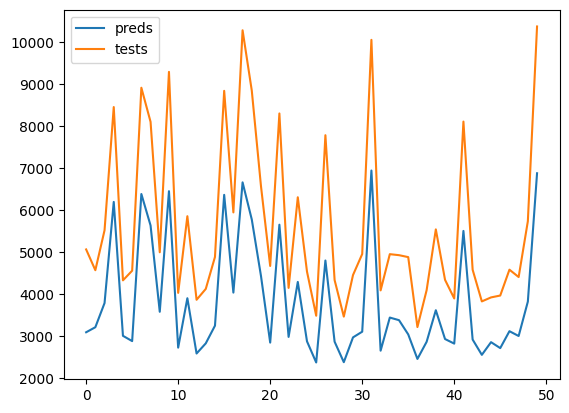

In [31]:
fig, ax = plt.subplots()

ax.plot(y_preds[-50:], label = 'preds')
ax.plot(y_test[-50:], label = 'tests')
plt.legend()
plt.show()

## Boom 500

#### dfs

In [313]:
# Raw X
X_raw = dff.drop(columns=['DATETIME','b500_pred','b1000_pred','c500_pred','c1000_pred','b500d','b1000d','c500d','c1000d']).values

In [314]:
# log X
X_log = np.log(dff.drop(columns=['DATETIME','b500_pred','b1000_pred','c500_pred','c1000_pred','b500d','b1000d','c500d','c1000d']).values)

In [315]:
# sin X
X_sin = np.sin(dff.drop(columns=['DATETIME','b500_pred','b1000_pred','c500_pred','c1000_pred','b500d','b1000d','c500d','c1000d']).values)

In [316]:
# x cols
X_cols = dff.drop(columns=['DATETIME','b500_pred','b1000_pred','c500_pred','c1000_pred','b500d','b1000d','c500d','c1000d'])

### RAW values

#### *XGBoost*

In [317]:
y = dff['b500d'].values
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42)


In [318]:
model = XGBClassifier(device='gpu', eta=0.1, max_depth=50, sampling_method='gradient_based', use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=50,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [319]:
# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # For ROC curve

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 76.20%


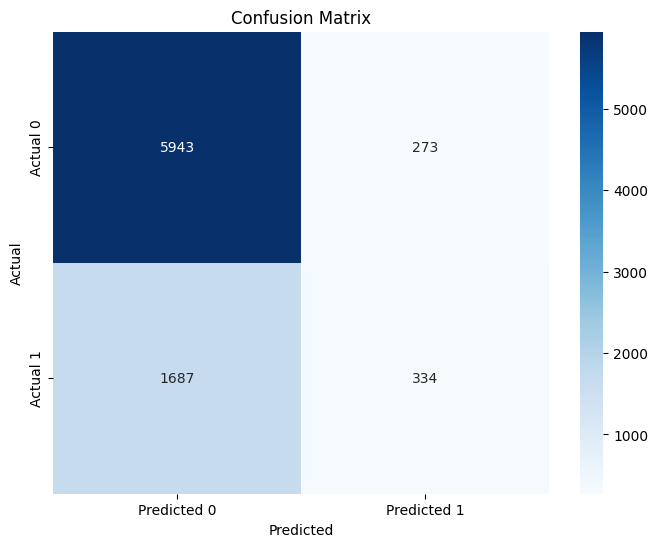

In [320]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


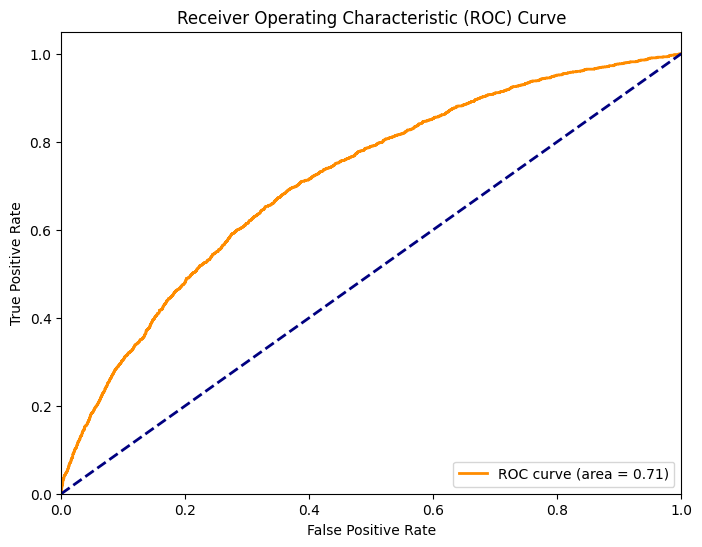

In [321]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


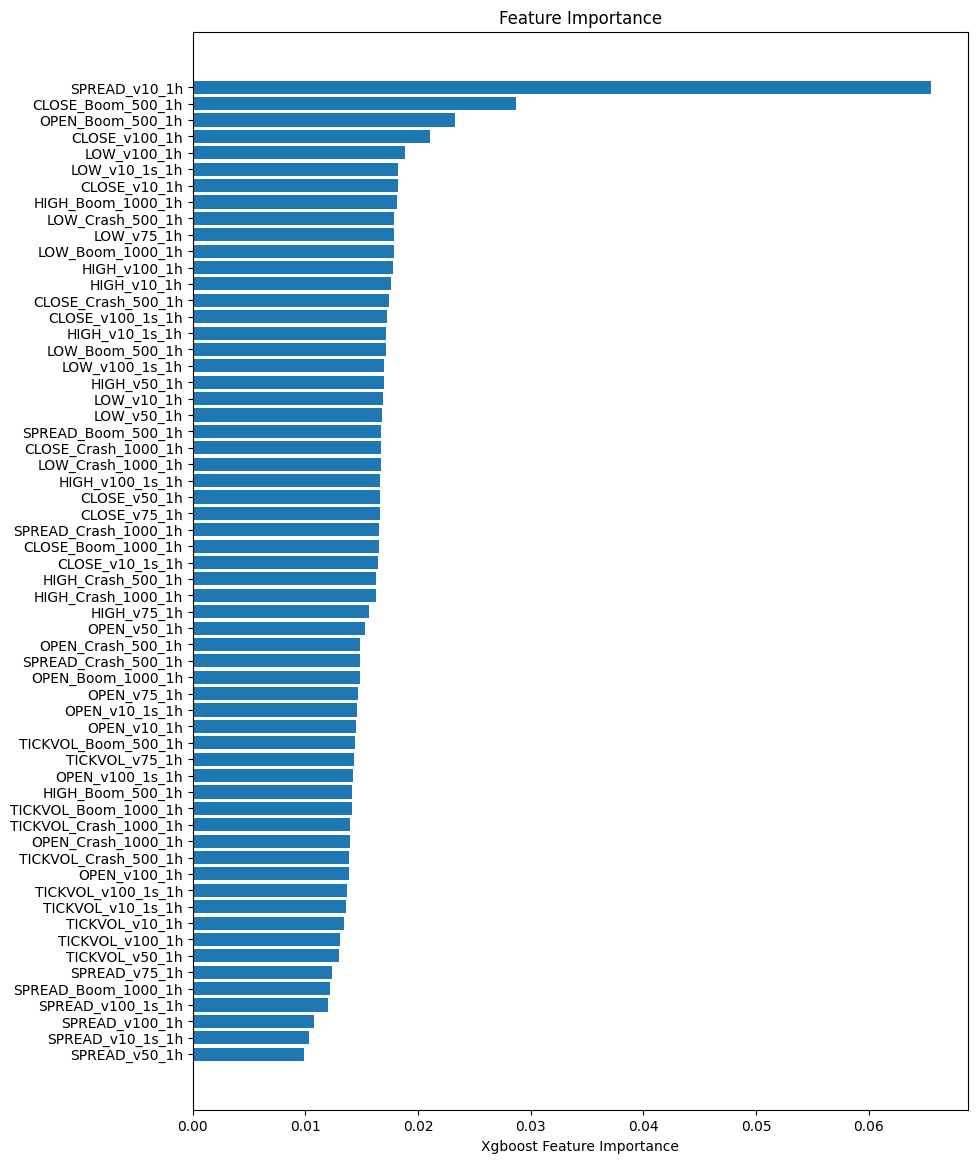

In [322]:
# Plot feature importance
plt.figure(figsize=(10, 14))
feature_importances = model.feature_importances_
sorted_idx = feature_importances.argsort()
plt.barh(X_cols.columns[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.title("Feature Importance")
plt.show()


#### *KNN*

In [323]:
# Initialize the k-NN model
knn = KNeighborsClassifier(n_neighbors=10) 

# Train the model
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)
y_proba = knn.predict_proba(X_test)[:, 1]

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 74.38%


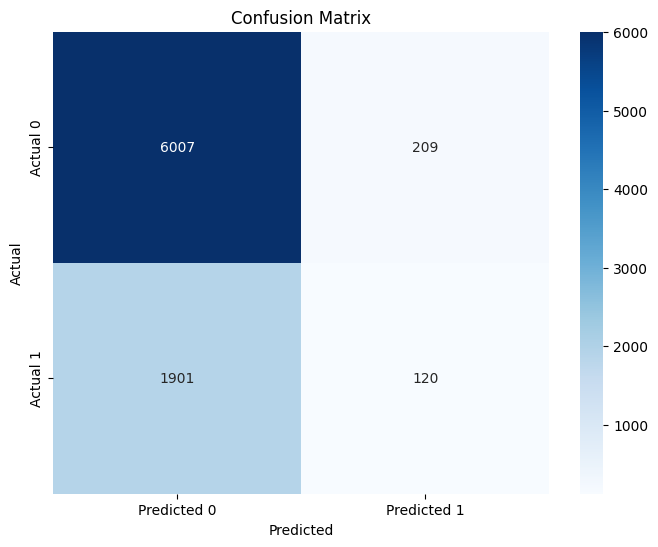

In [324]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

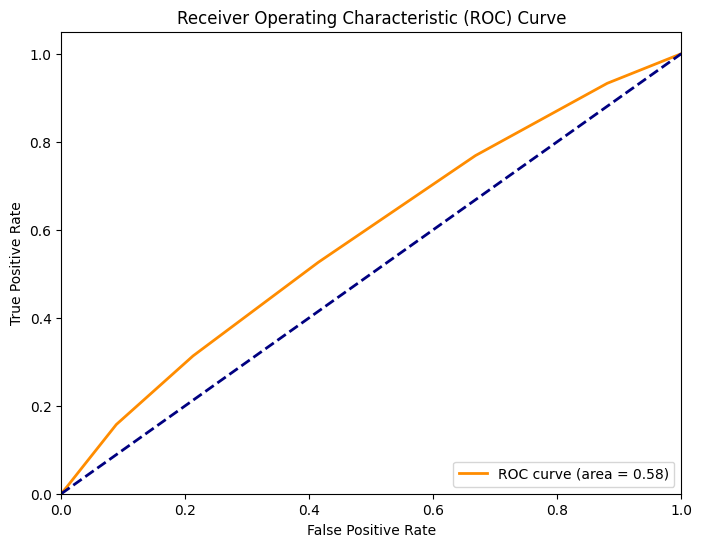

In [325]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Log values

#### *XGBoost*

In [326]:
y = dff['b500d'].values
X_train, X_test, y_train, y_test = train_test_split(X_log, y, test_size=0.2, random_state=42)

model = XGBClassifier(device='gpu', eta=0.1, max_depth=60, sampling_method='gradient_based', use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # For ROC curve
# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 76.42%


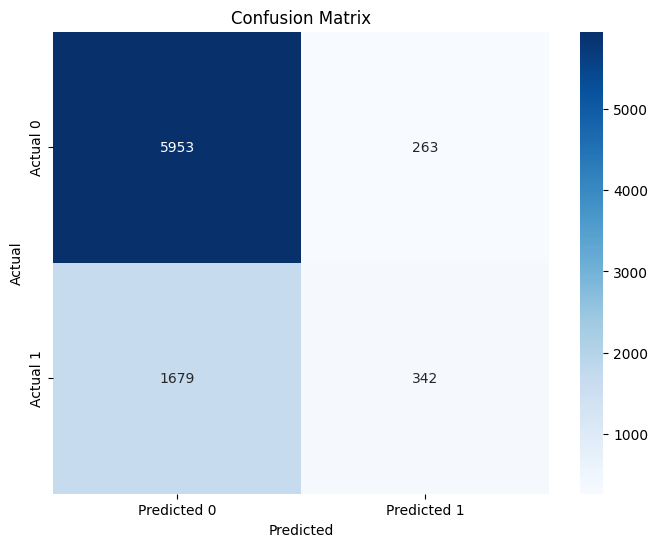

In [327]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

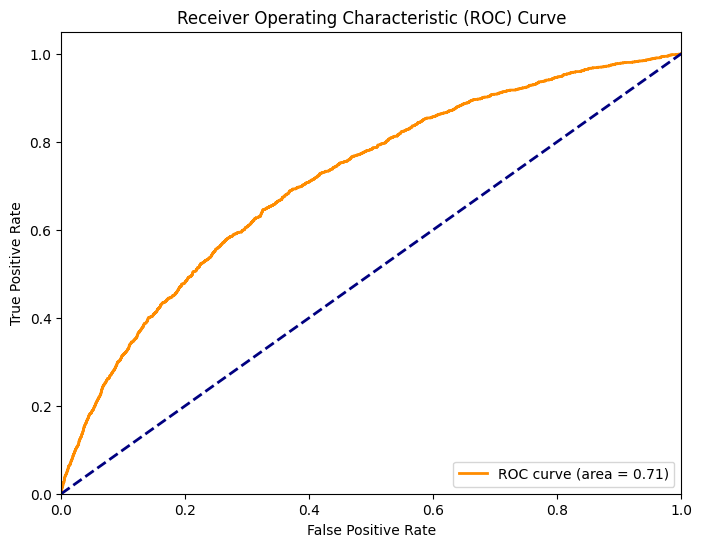

In [328]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

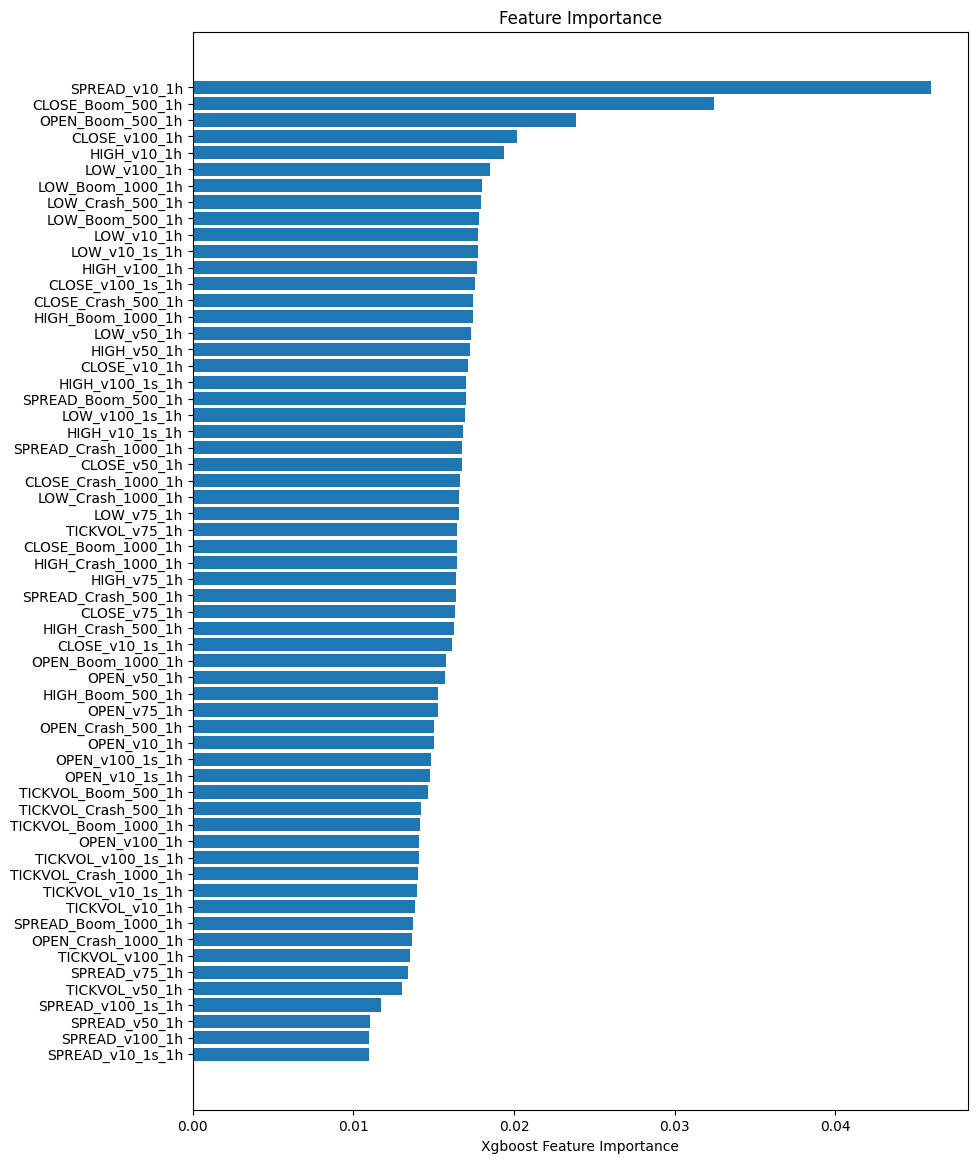

In [329]:
# Plot feature importance
plt.figure(figsize=(10, 14))
feature_importances = model.feature_importances_
sorted_idx = feature_importances.argsort()
plt.barh(X_cols.columns[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.title("Feature Importance")
plt.show()

#### *KNN*

In [330]:
# Initialize the k-NN model
knn = KNeighborsClassifier(n_neighbors=10) 

# Train the model
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)
y_proba = knn.predict_proba(X_test)[:, 1]

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 75.50%


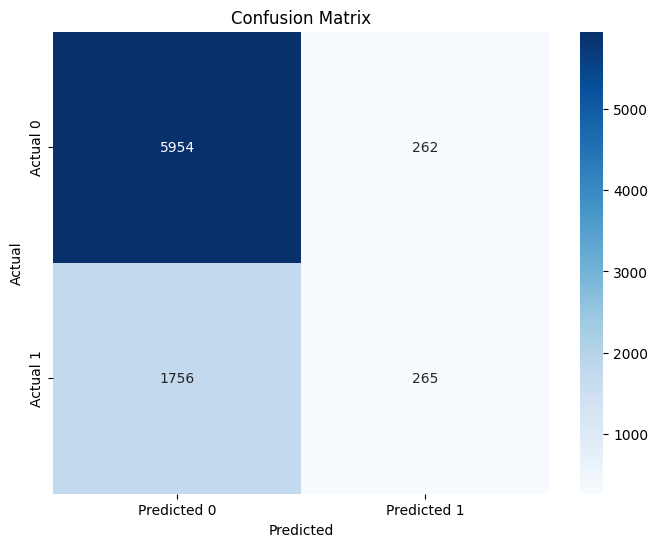

In [331]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

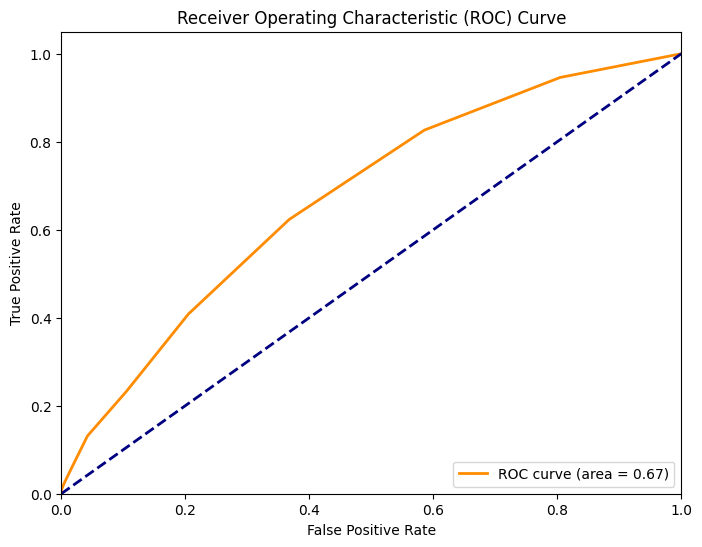

In [332]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Sin values

#### *XGBoost*

In [333]:
y = dff['b500d'].values
X_train, X_test, y_train, y_test = train_test_split(X_sin, y, test_size=0.2, random_state=42)

model = XGBClassifier(device='gpu', eta=0.1, max_depth=60, sampling_method='gradient_based', use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=60,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [334]:
# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # For ROC curve
# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 75.22%


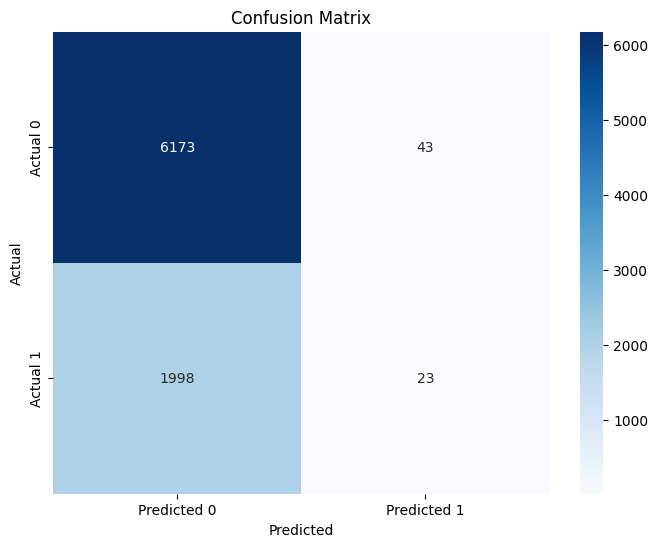

In [335]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

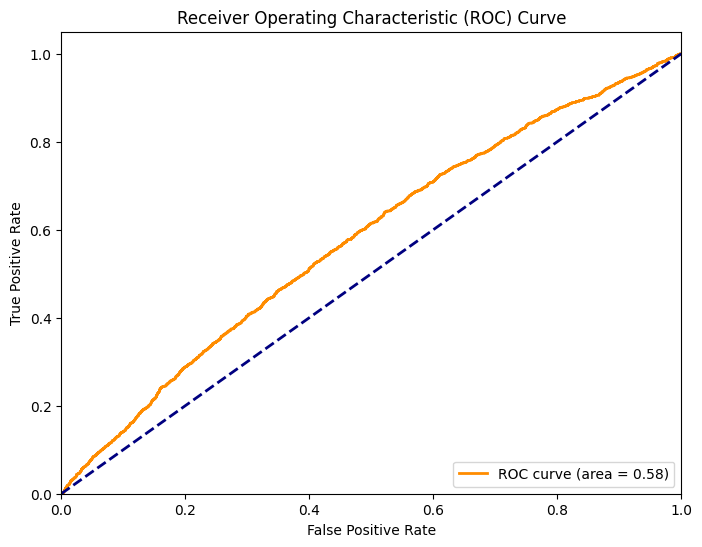

In [336]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

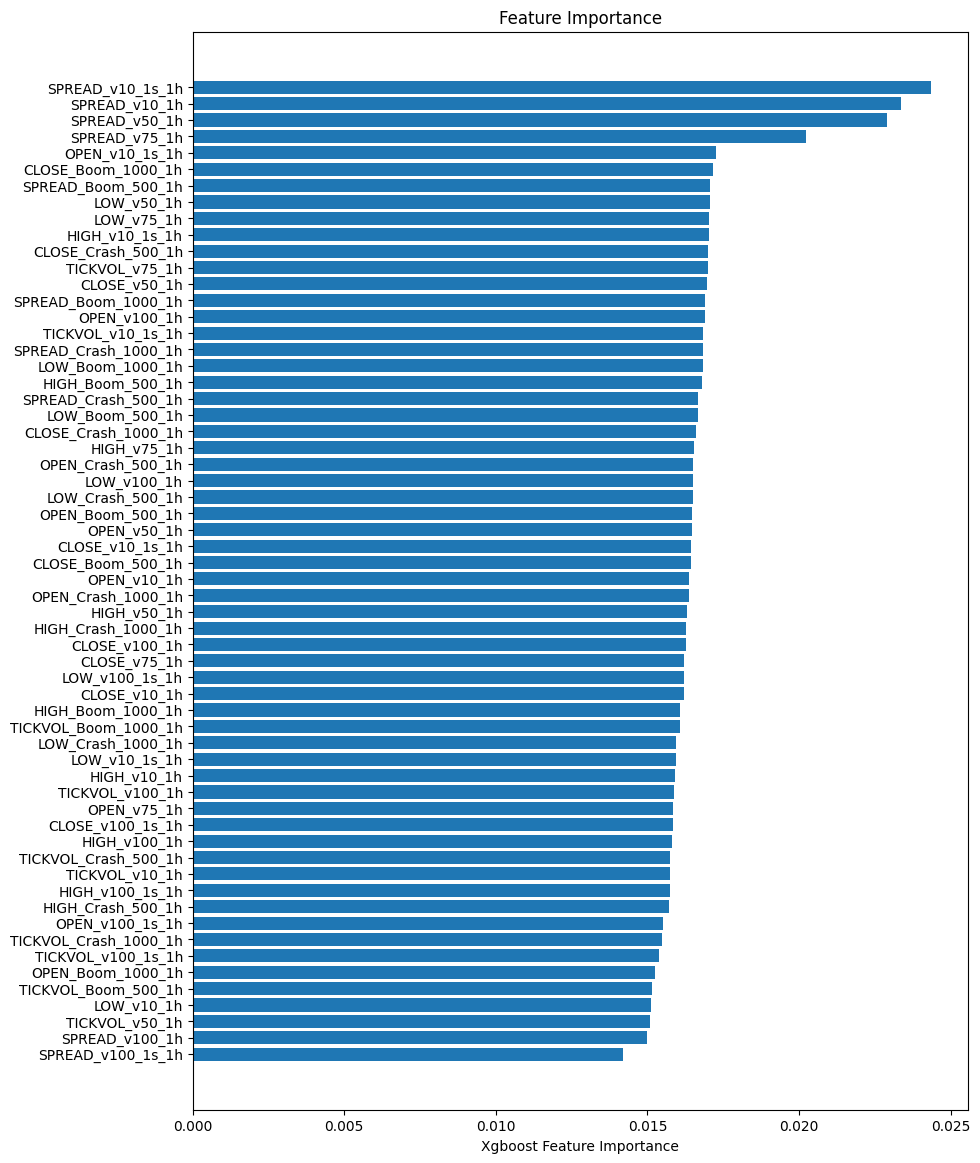

In [337]:
# Plot feature importance
plt.figure(figsize=(10, 14))
feature_importances = model.feature_importances_
sorted_idx = feature_importances.argsort()
plt.barh(X_cols.columns[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.title("Feature Importance")
plt.show()

#### *KNN*

In [338]:
# Initialize the k-NN model
knn = KNeighborsClassifier(n_neighbors=10) 

# Train the model
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)
y_proba = knn.predict_proba(X_test)[:, 1]

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 74.85%


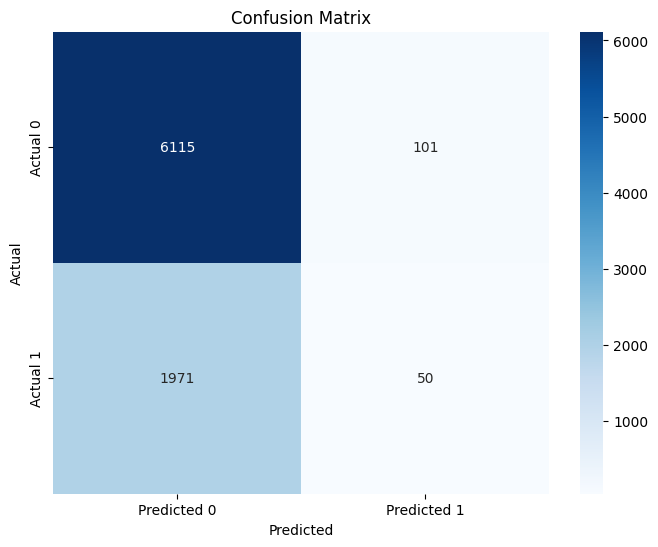

In [339]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

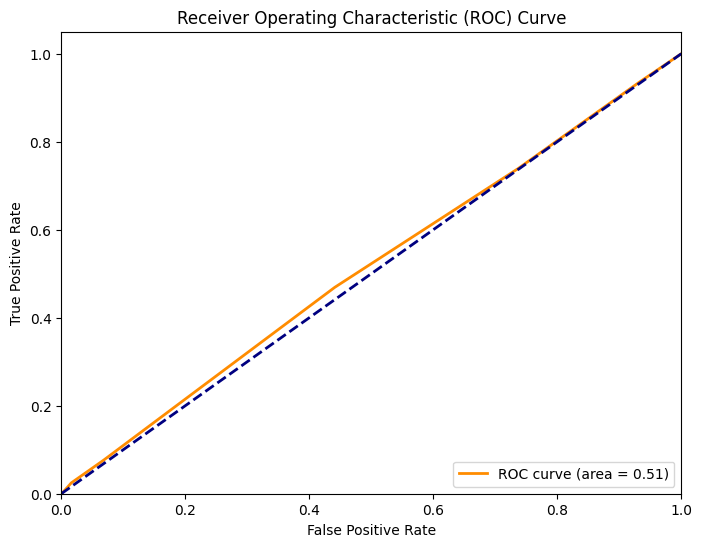

In [340]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Standard Scaler

#### *XGBoost*

In [341]:
y = dff['b500d'].values

X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = XGBClassifier(device='gpu', eta=0.1, max_depth=60, sampling_method='gradient_based', use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=60,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [342]:
# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # For ROC curve
# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 76.12%


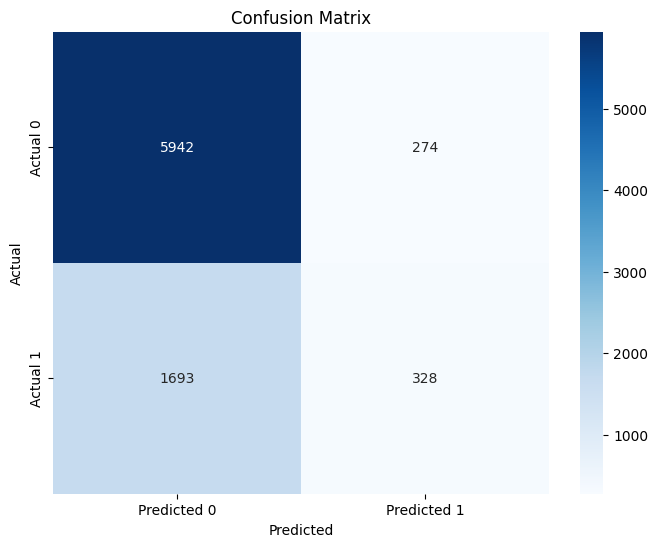

In [343]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

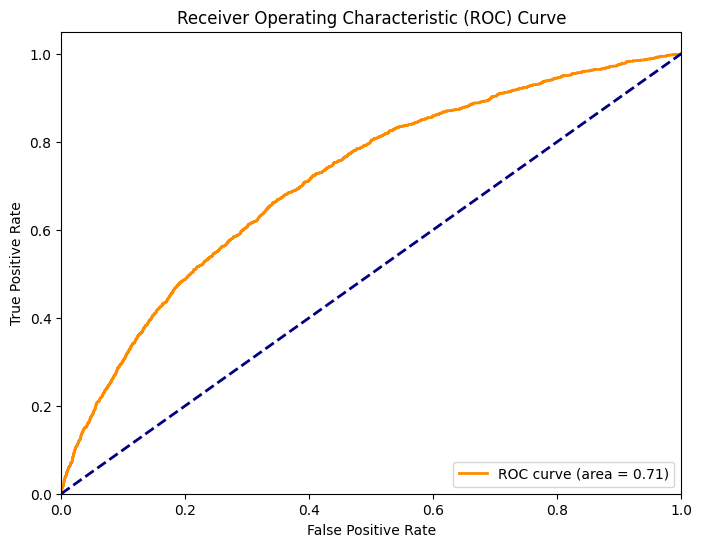

In [344]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


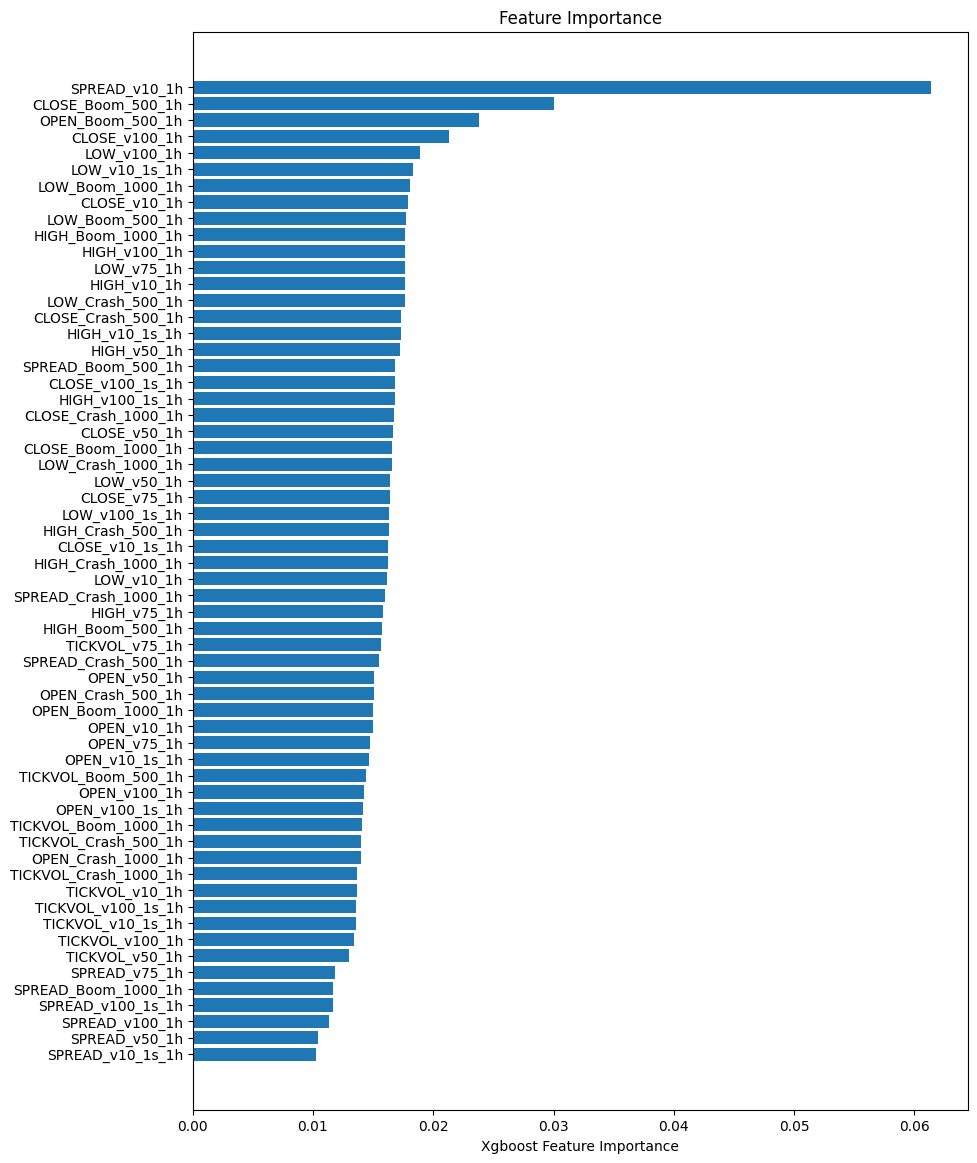

In [345]:
# Plot feature importance
plt.figure(figsize=(10, 14))
feature_importances = model.feature_importances_
sorted_idx = feature_importances.argsort()
plt.barh(X_cols.columns[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.title("Feature Importance")
plt.show()

#### *KNN*

In [346]:
# Initialize the k-NN model
knn = KNeighborsClassifier(n_neighbors=10) 

# Train the model
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)
y_proba = knn.predict_proba(X_test)[:, 1]

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 74.81%


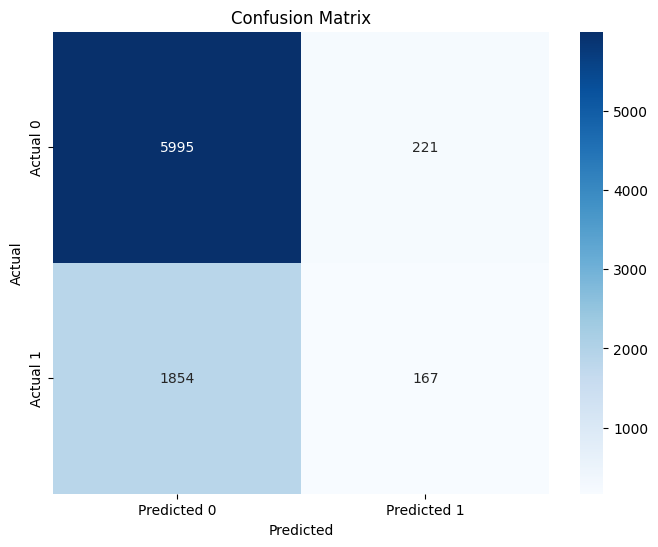

In [347]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

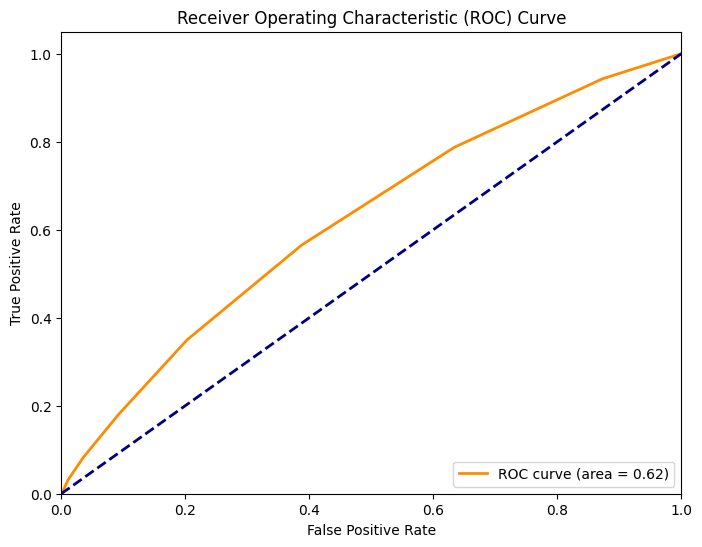

In [348]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Boom 1000

### RAW values

#### *XGBoost*

In [349]:

y = dff['b1000d'].values

In [350]:
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42)

In [351]:
model = XGBClassifier(device='gpu', eta=0.1, max_depth=60, sampling_method='gradient_based', use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=60,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [352]:
# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # For ROC curve

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 73.23%


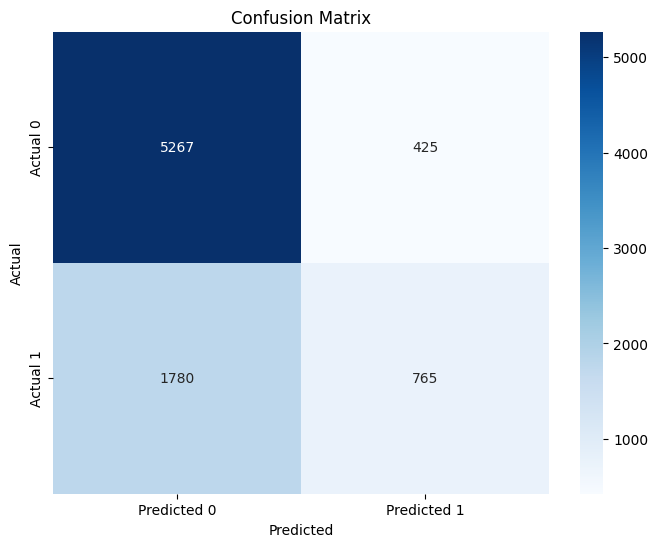

In [353]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

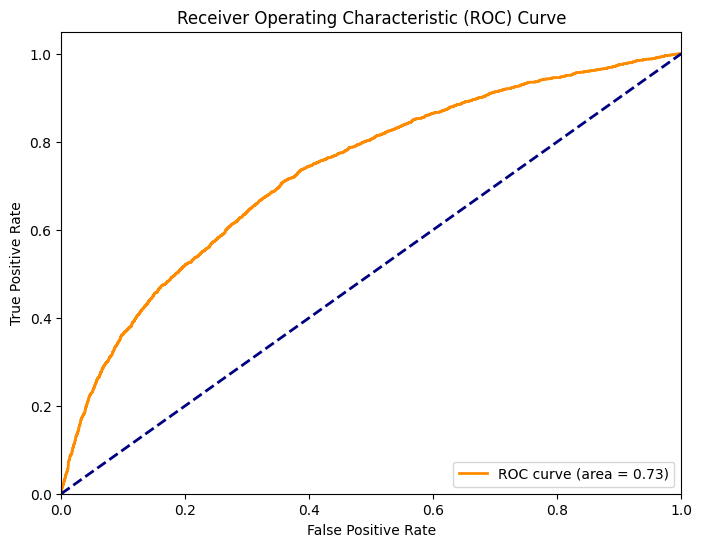

In [354]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

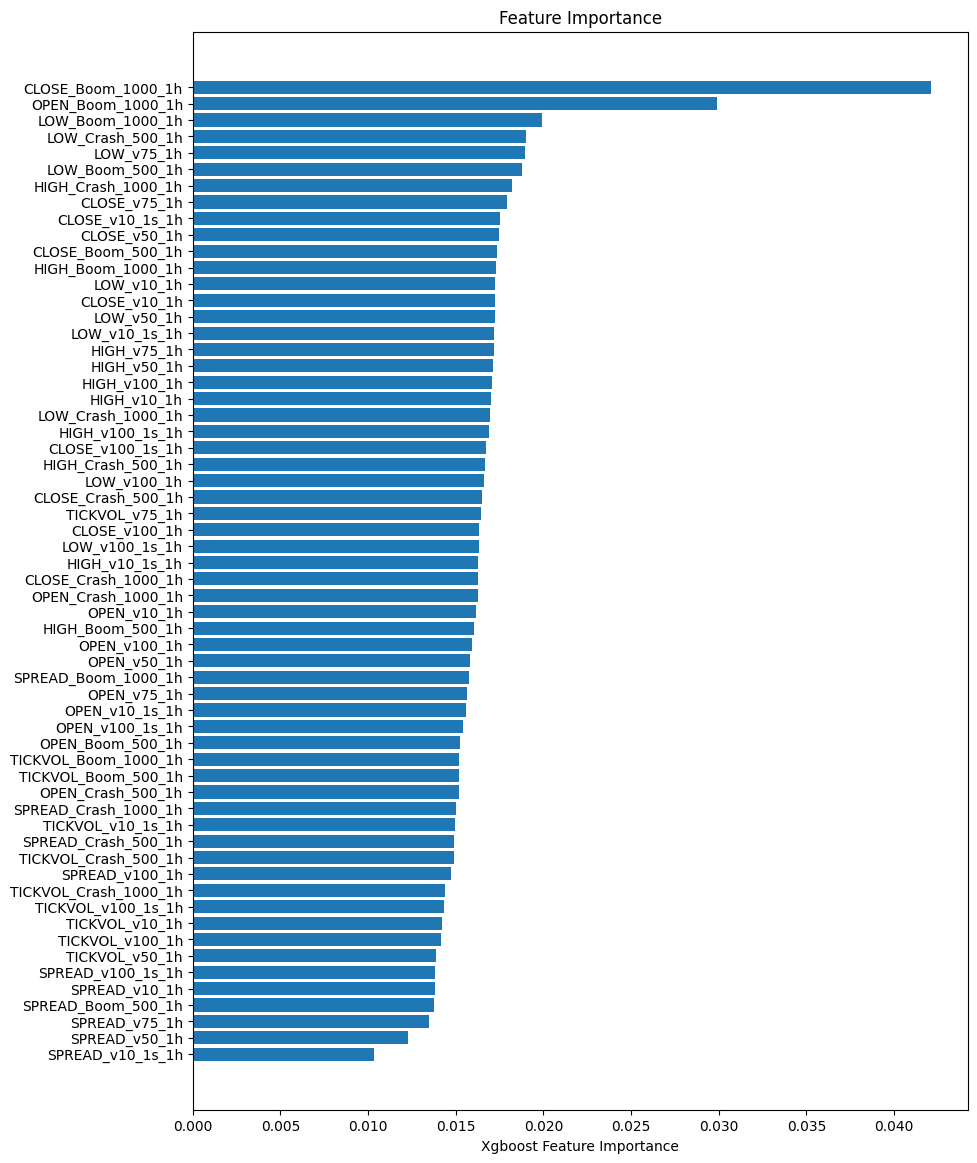

In [355]:
# Plot feature importance
plt.figure(figsize=(10, 14))
feature_importances = model.feature_importances_
sorted_idx = feature_importances.argsort()
plt.barh(X_cols.columns[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.title("Feature Importance")
plt.show()

#### *KNN*

In [356]:
# Initialize the k-NN model
knn = KNeighborsClassifier(n_neighbors=10) 

# Train the model
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)
y_proba = knn.predict_proba(X_test)[:, 1]

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 67.37%


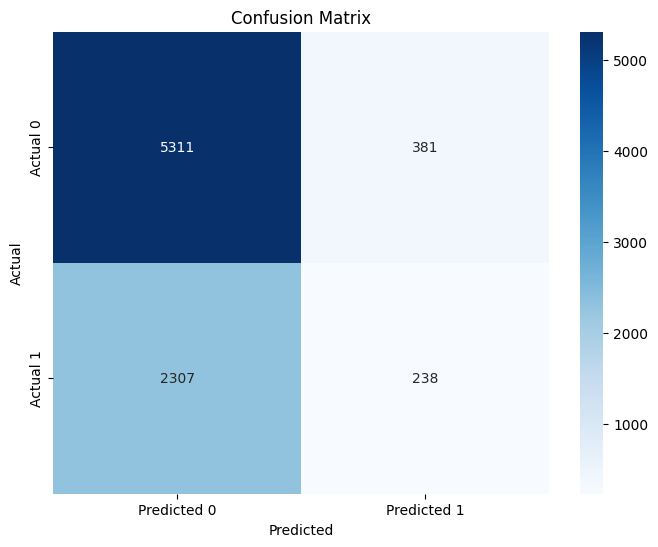

In [357]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

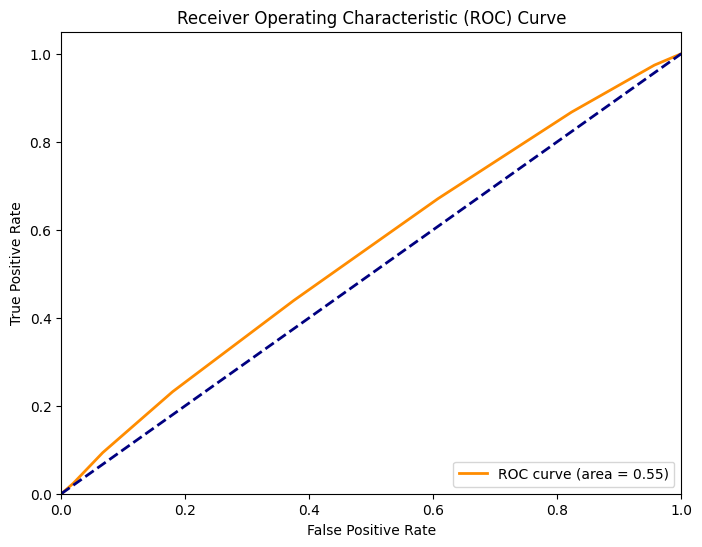

In [358]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Log values

#### *XGBoost*

In [359]:

y = dff['b1000d'].values


In [360]:
X_train, X_test, y_train, y_test = train_test_split(X_log, y, test_size=0.2, random_state=42)

model = XGBClassifier(device='gpu', eta=0.1, max_depth=60, sampling_method='gradient_based', use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=60,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [361]:
# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # For ROC curve
# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 72.94%


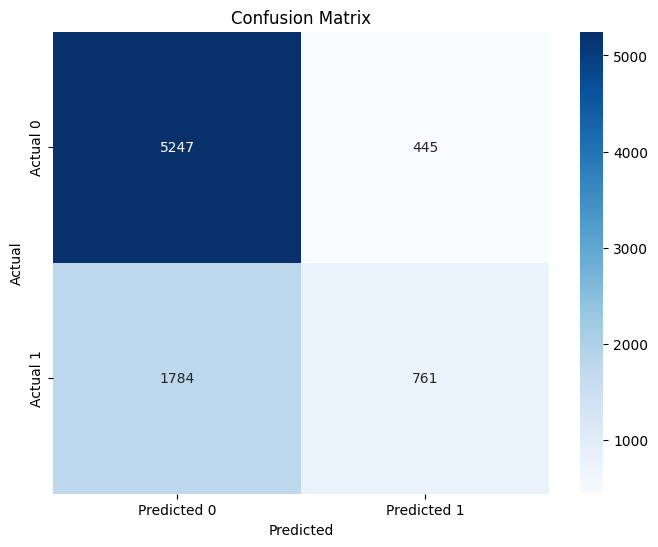

In [362]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


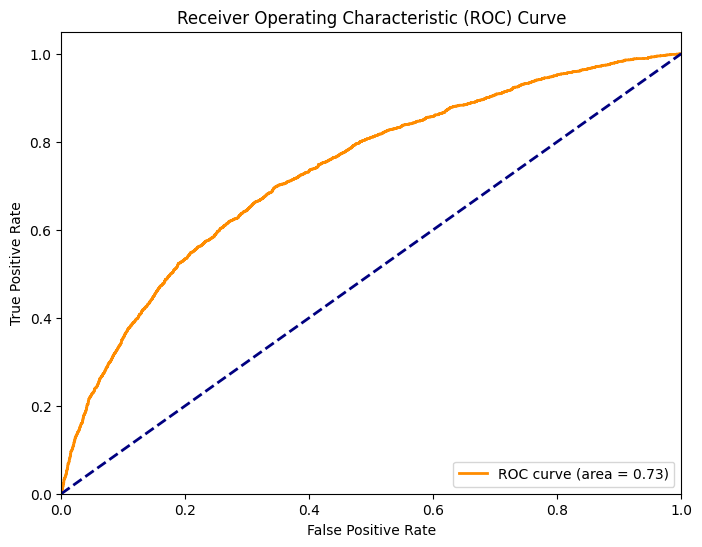

In [363]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


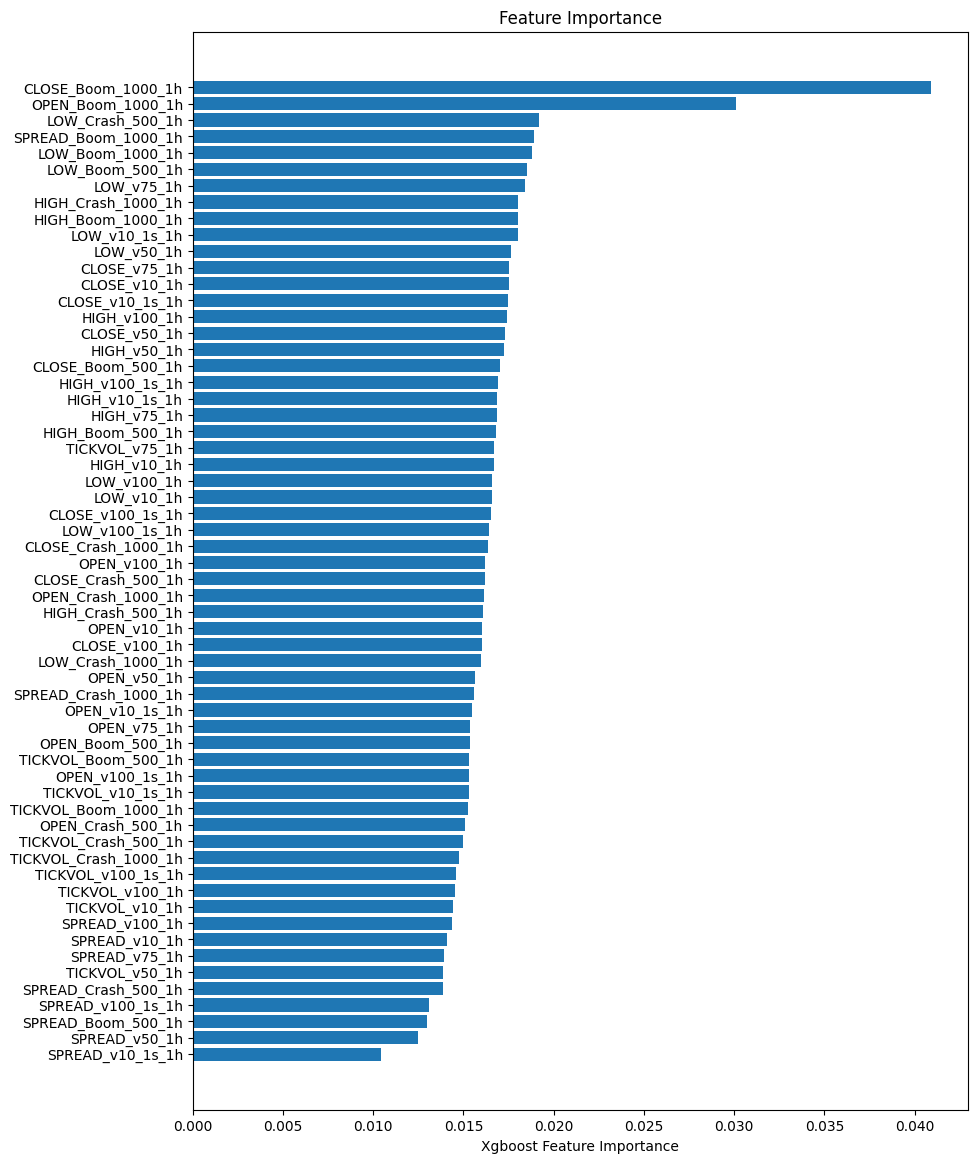

In [364]:
# Plot feature importance
plt.figure(figsize=(10, 14))
feature_importances = model.feature_importances_
sorted_idx = feature_importances.argsort()
plt.barh(X_cols.columns[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.title("Feature Importance")
plt.show()

#### *KNN*

In [365]:
# Initialize the k-NN model
knn = KNeighborsClassifier(n_neighbors=5) 

# Train the model
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)
y_proba = knn.predict_proba(X_test)[:, 1]

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 70.69%


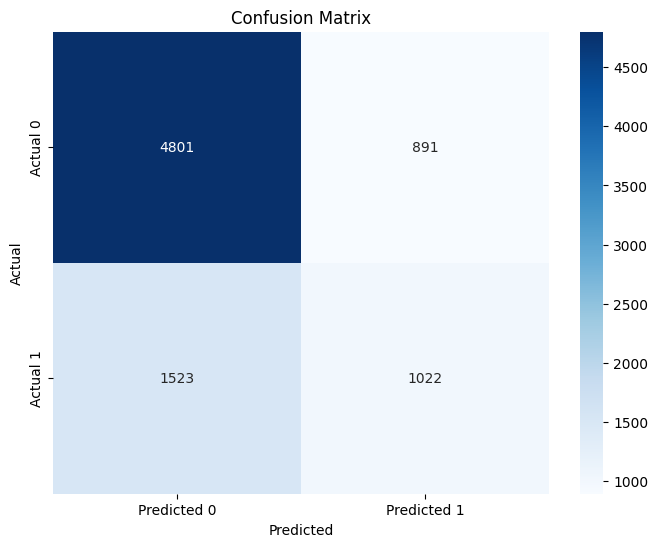

In [366]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

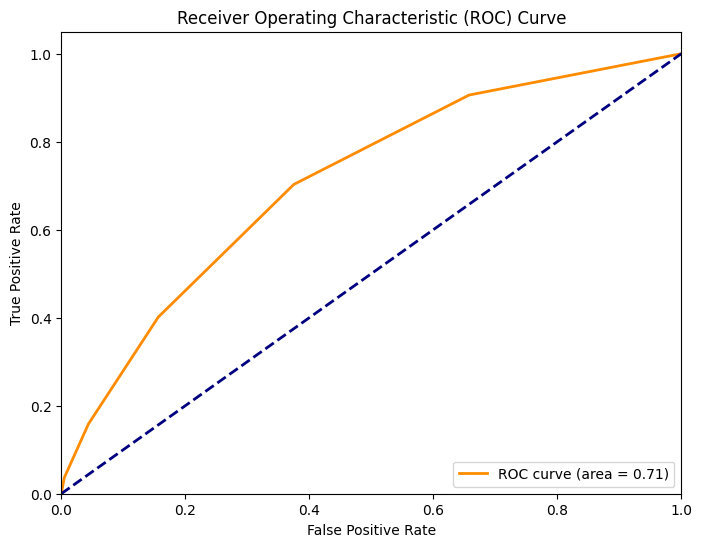

In [367]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Sin Values

#### *XGBoost*

In [368]:
y = dff['b1000d'].values
X_train, X_test, y_train, y_test = train_test_split(X_sin, y, test_size=0.2, random_state=42)

model = XGBClassifier(device='gpu', eta=0.1, max_depth=60, sampling_method='gradient_based', use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=60,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [369]:
# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # For ROC curve
# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 69.02%


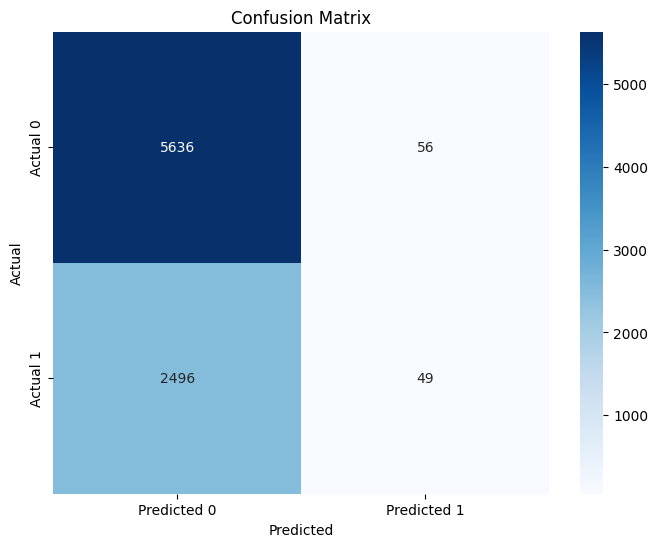

In [370]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

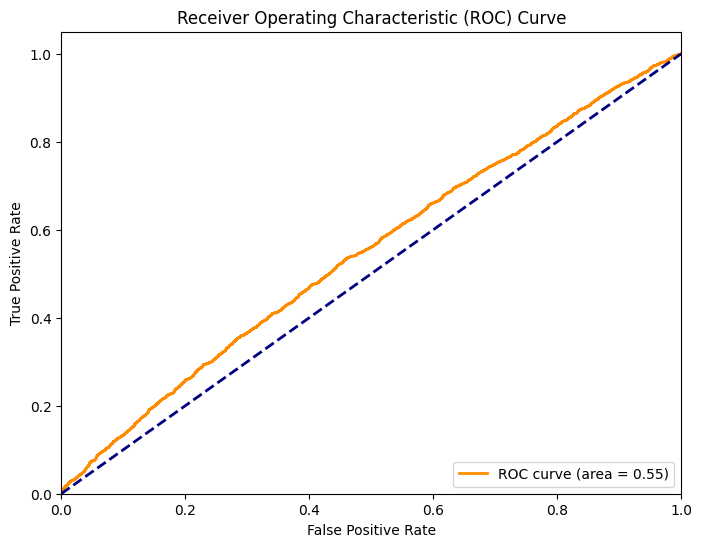

In [371]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

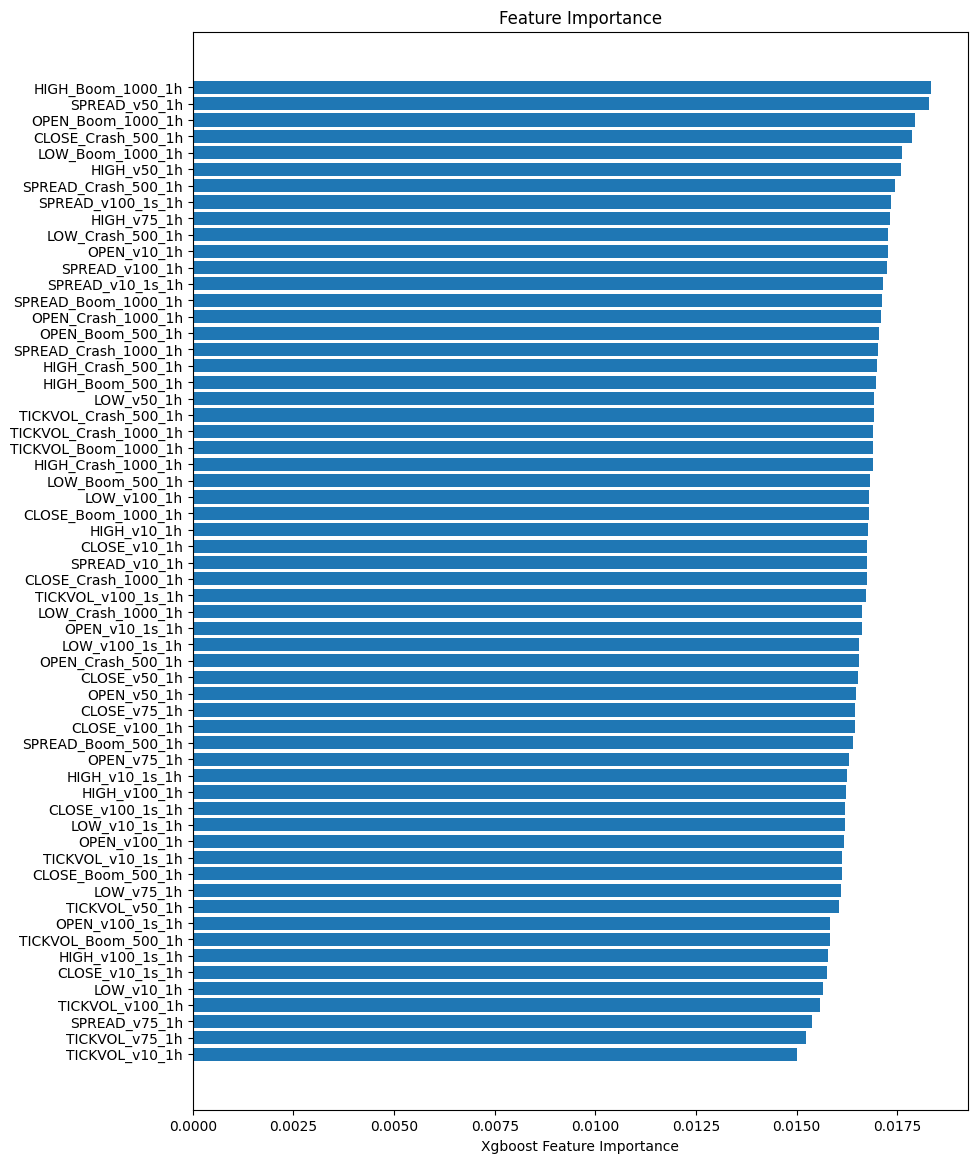

In [372]:
# Plot feature importance
plt.figure(figsize=(10, 14))
feature_importances = model.feature_importances_
sorted_idx = feature_importances.argsort()
plt.barh(X_cols.columns[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.title("Feature Importance")
plt.show()

#### *KNN*

In [373]:
# Initialize the k-NN model
knn = KNeighborsClassifier(n_neighbors=5) 

# Train the model
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)
y_proba = knn.predict_proba(X_test)[:, 1]

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 62.67%


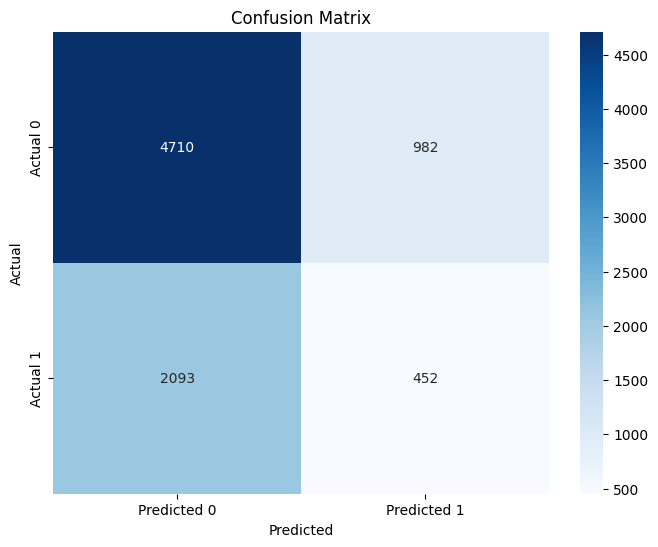

In [374]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

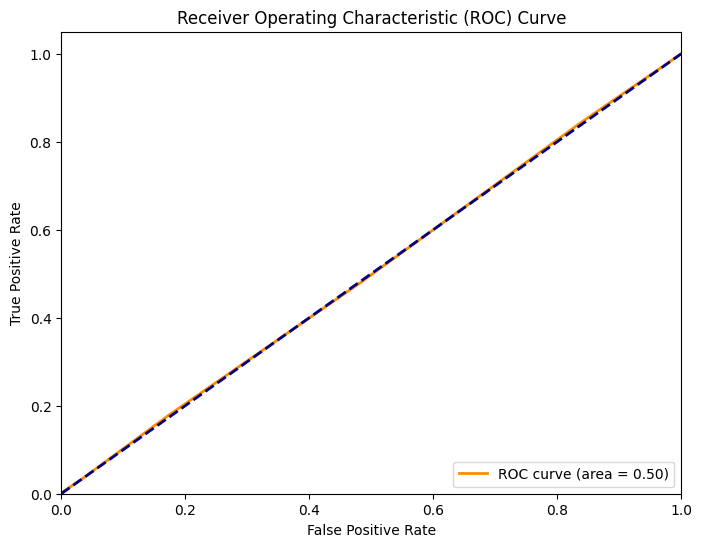

In [375]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Standard scaler

#### *XGBoost*

In [376]:

y = dff['b1000d'].values


In [377]:
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = XGBClassifier(device='gpu', eta=0.1, max_depth=60, sampling_method='gradient_based', use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=60,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [378]:
# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # For ROC curve
# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 73.35%


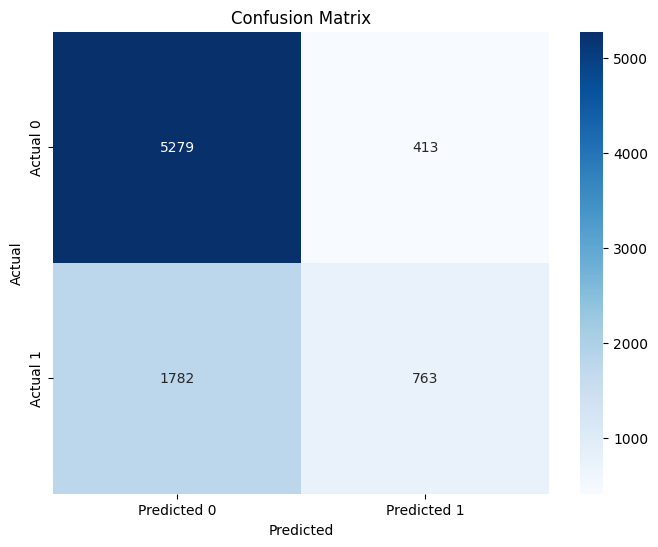

In [379]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

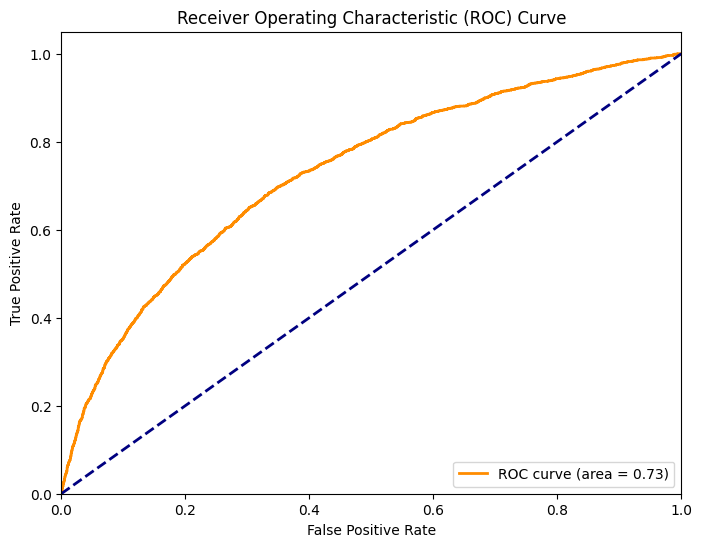

In [380]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


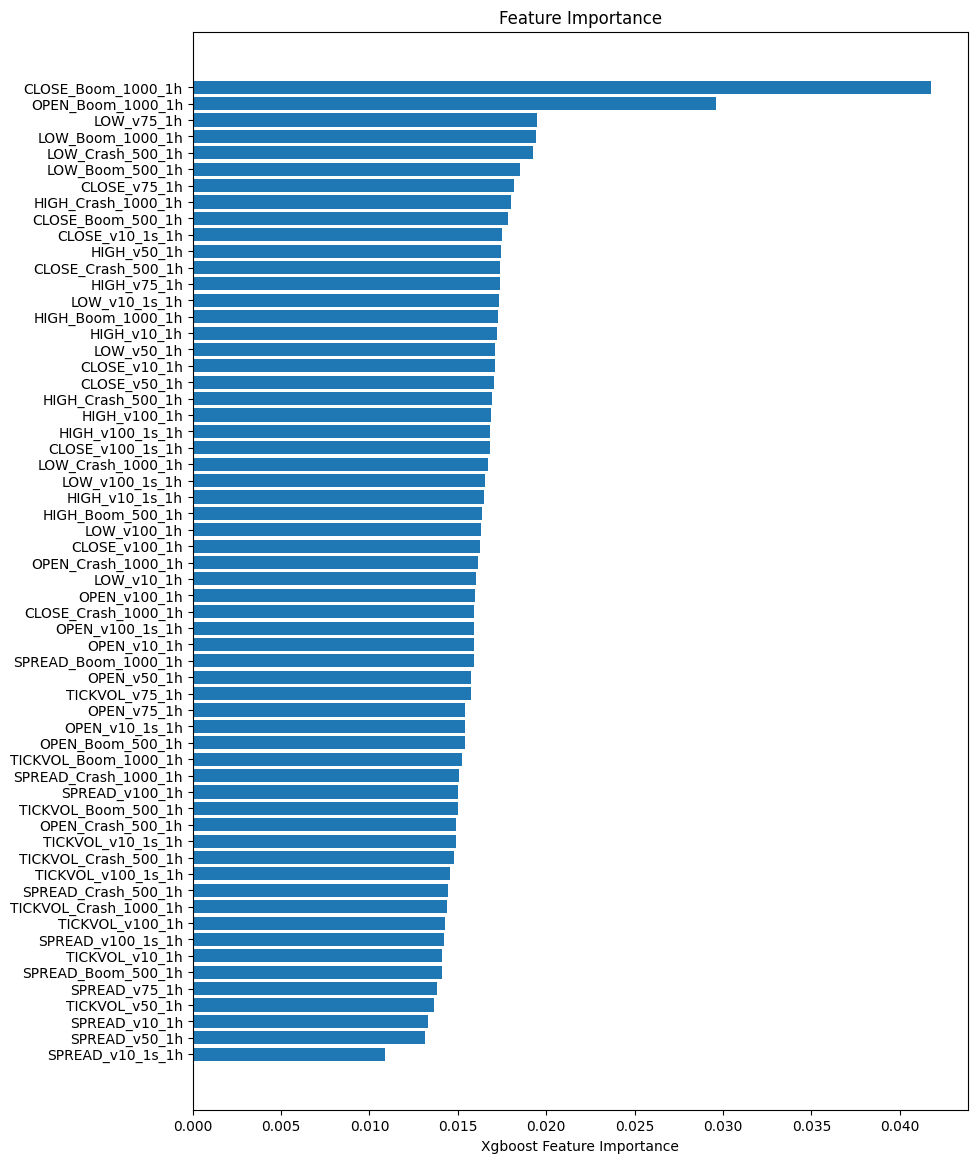

In [381]:
# Plot feature importance
plt.figure(figsize=(10, 14))
feature_importances = model.feature_importances_
sorted_idx = feature_importances.argsort()
plt.barh(X_cols.columns[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.title("Feature Importance")
plt.show()

#### *KNN*

In [382]:
# Initialize the k-NN model
knn = KNeighborsClassifier(n_neighbors=5) 

# Train the model
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)
y_proba = knn.predict_proba(X_test)[:, 1]

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 65.87%


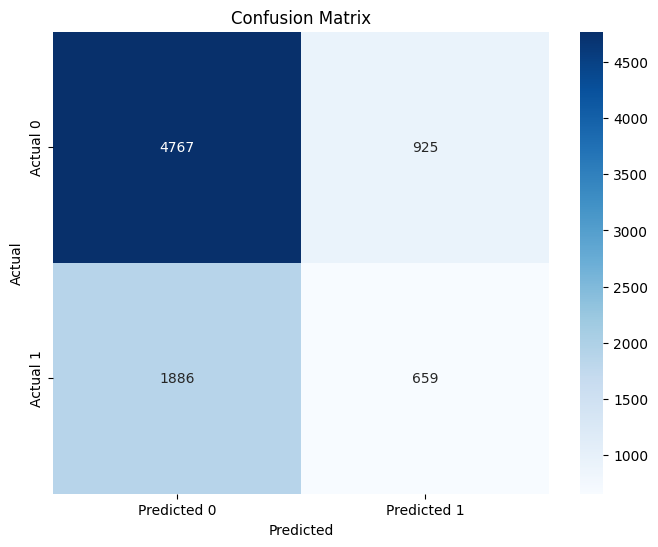

In [383]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


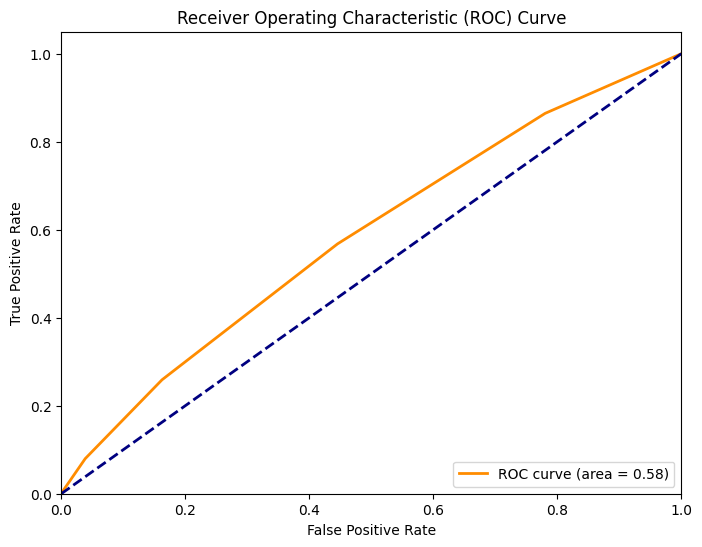

In [384]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Crash 500

### Raw Values

#### *XGboost*

In [385]:

y = dff['c500d'].values

In [386]:
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42)

In [387]:
model = XGBClassifier(device='gpu', eta=0.1, max_depth=50, sampling_method='gradient_based', use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=50,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [388]:
# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # For ROC curve

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 73.91%


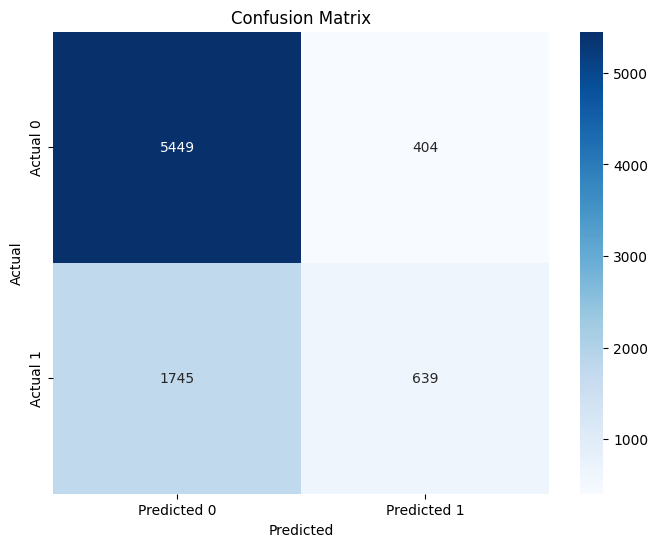

In [389]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

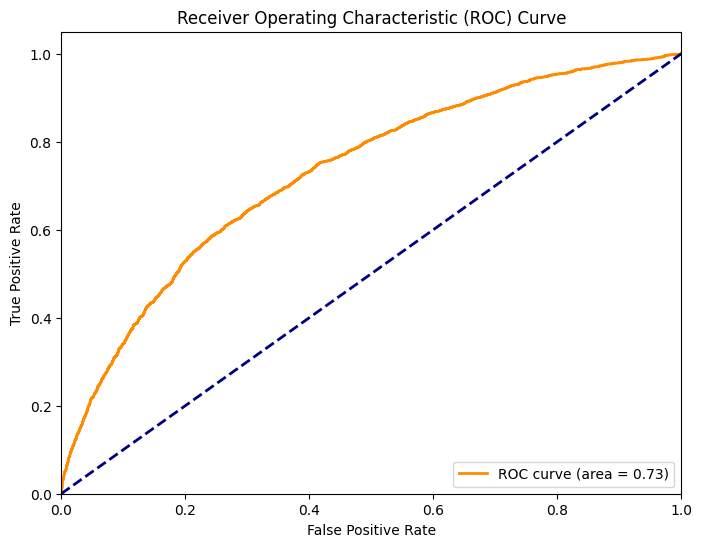

In [390]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

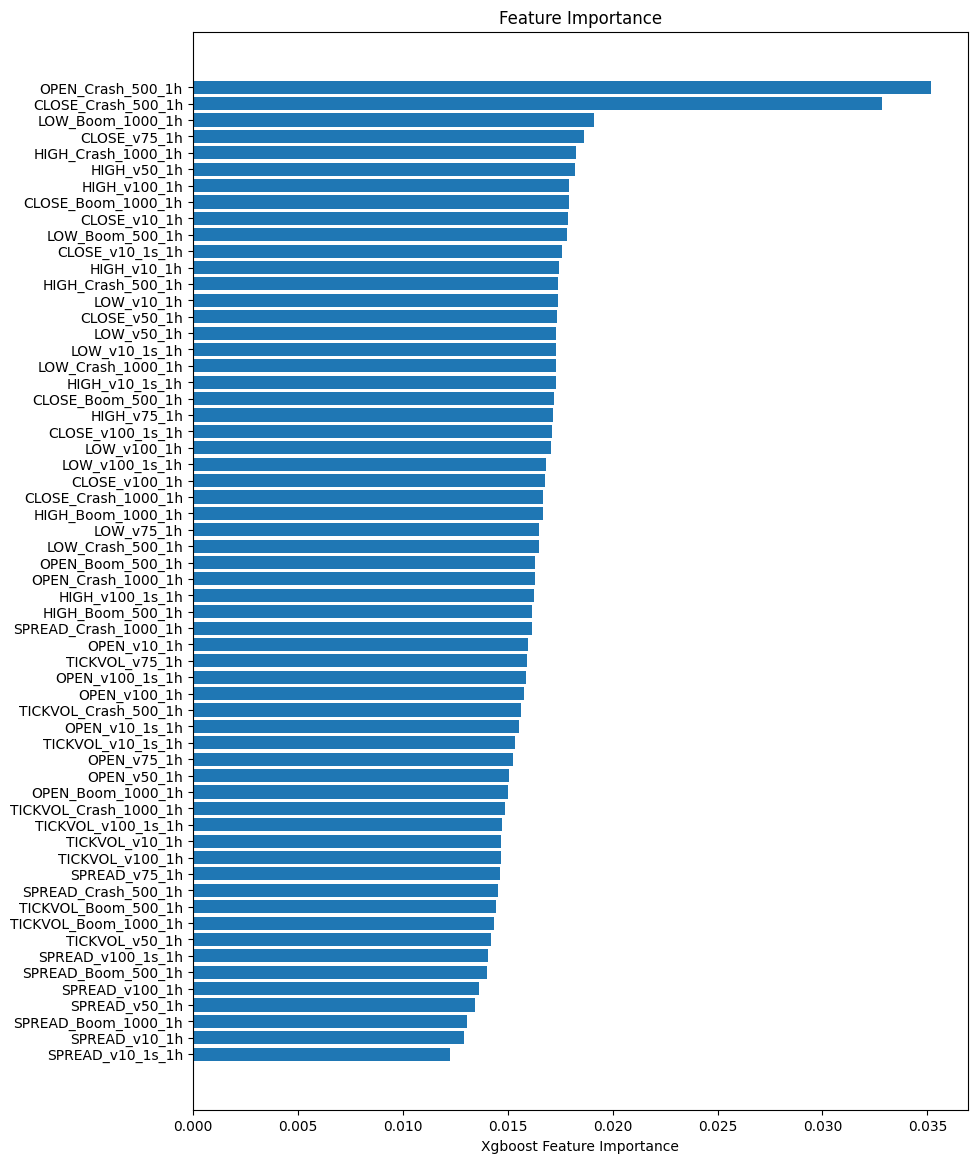

In [391]:
# Plot feature importance
plt.figure(figsize=(10, 14))
feature_importances = model.feature_importances_
sorted_idx = feature_importances.argsort()
plt.barh(X_cols.columns[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.title("Feature Importance")
plt.show()

#### *KNN*

In [392]:
# Initialize the k-NN model
knn = KNeighborsClassifier(n_neighbors=25) 

# Train the model
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)
y_proba = knn.predict_proba(X_test)[:, 1]

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 70.60%


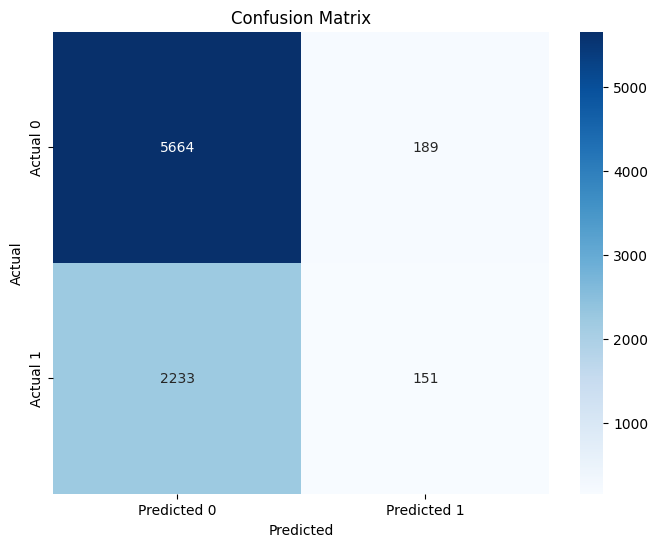

In [393]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

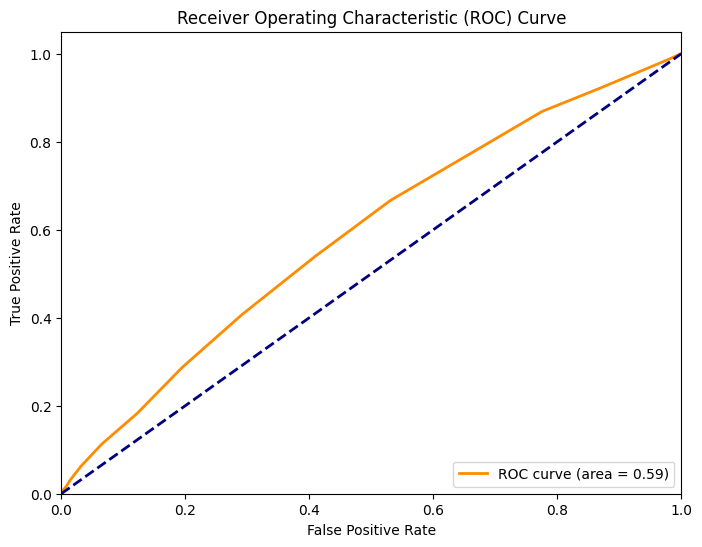

In [394]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Log values

#### *XGBoost*

In [395]:
y = dff['c500d'].values


In [396]:
X_train, X_test, y_train, y_test = train_test_split(X_log, y, test_size=0.2, random_state=42)

model = XGBClassifier(device='gpu', eta=0.1, max_depth=60, sampling_method='gradient_based', use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=60,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [397]:
# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # For ROC curve
# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 73.73%


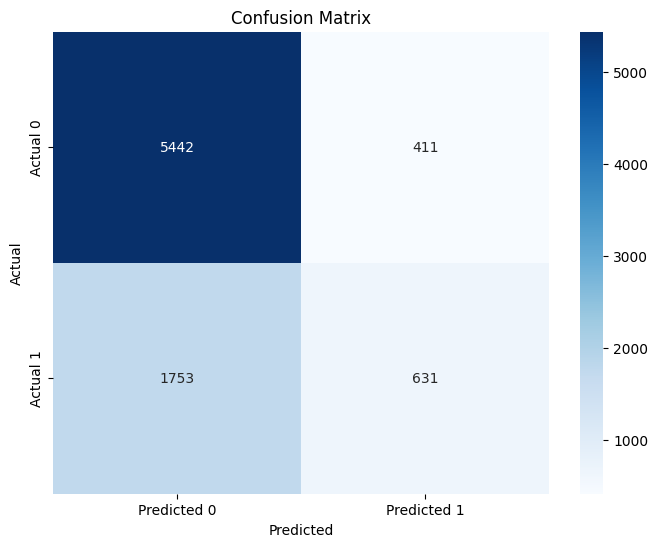

In [398]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

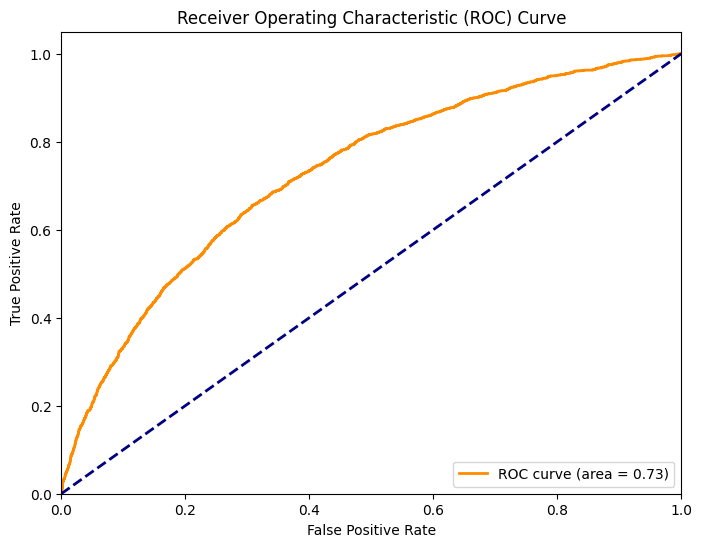

In [399]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


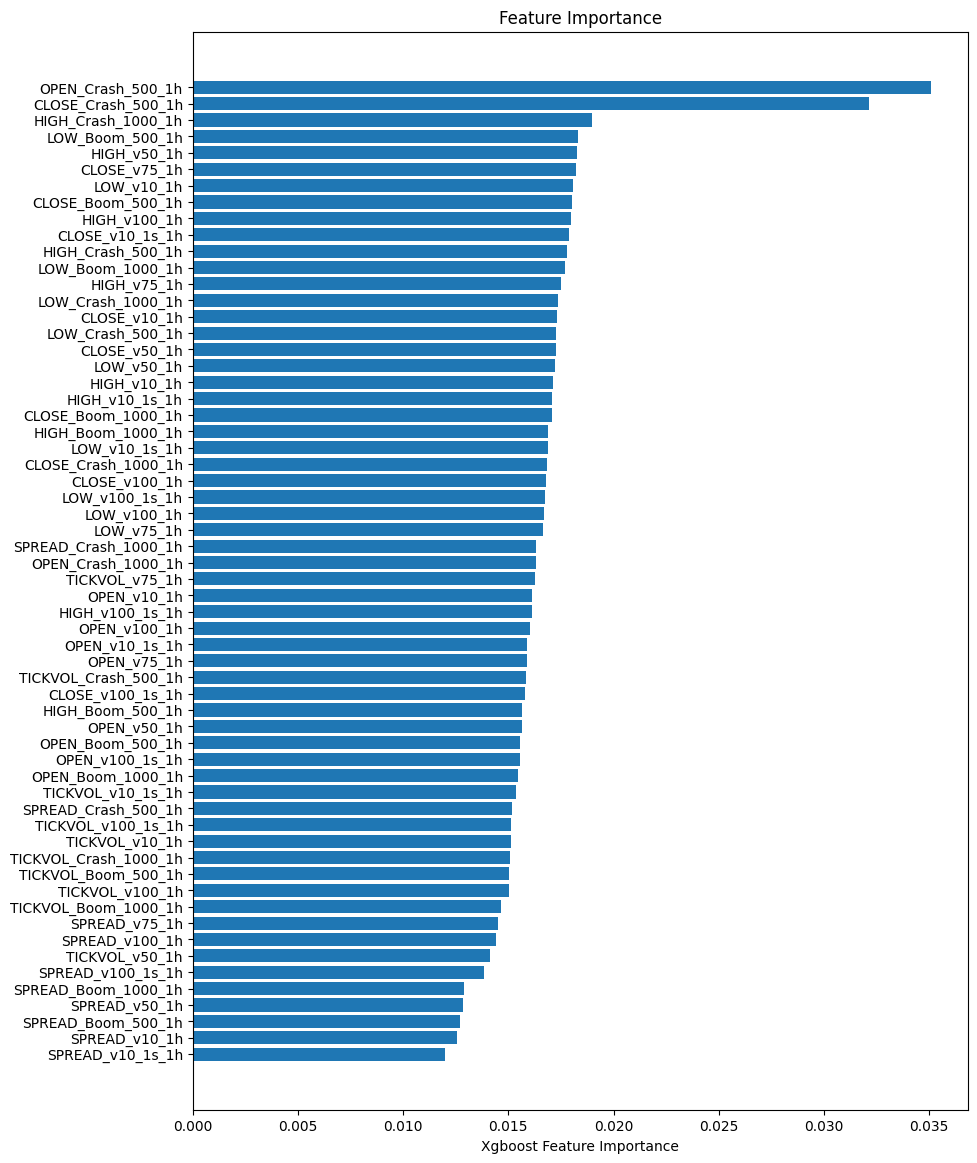

In [400]:
# Plot feature importance
plt.figure(figsize=(10, 14))
feature_importances = model.feature_importances_
sorted_idx = feature_importances.argsort()
plt.barh(X_cols.columns[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.title("Feature Importance")
plt.show()

#### *KNN*

In [401]:
# Initialize the k-NN model
knn = KNeighborsClassifier(n_neighbors=25) 


In [402]:
# Train the model
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)
y_proba = knn.predict_proba(X_test)[:, 1]

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 69.90%


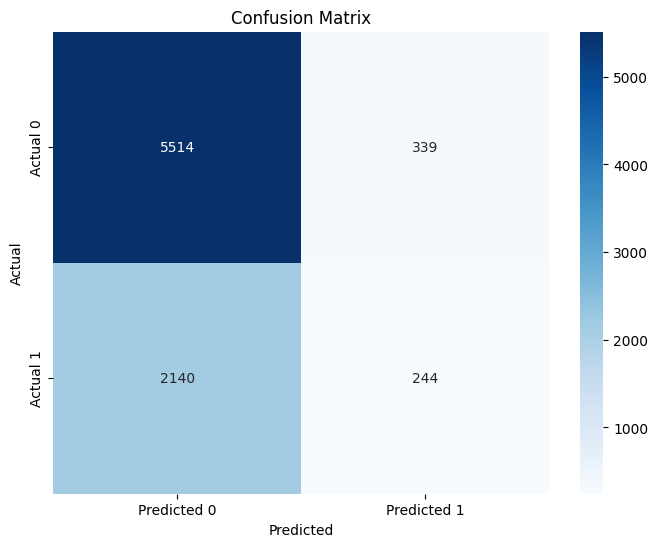

In [403]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

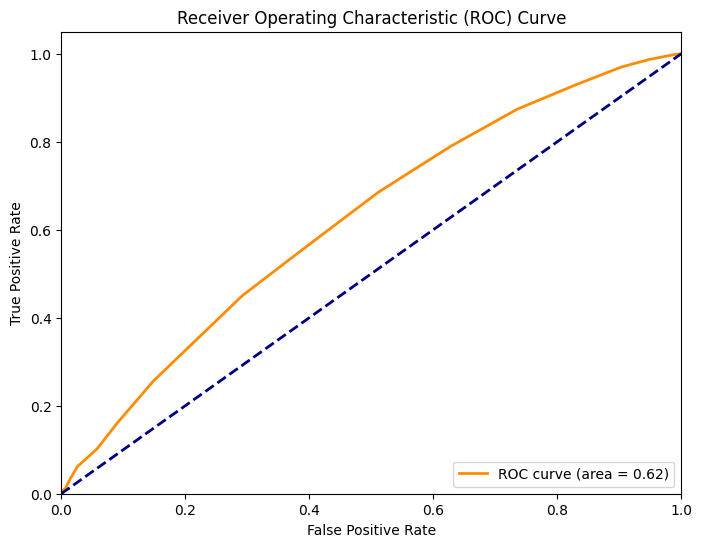

In [404]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Sin Values

#### *XGBoost*

In [405]:
y = dff['c500d'].values

In [406]:
X_train, X_test, y_train, y_test = train_test_split(X_sin, y, test_size=0.2, random_state=42)

model = XGBClassifier(device='gpu', eta=0.1, max_depth=60, sampling_method='gradient_based', use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=60,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [407]:
# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # For ROC curve
# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 70.63%


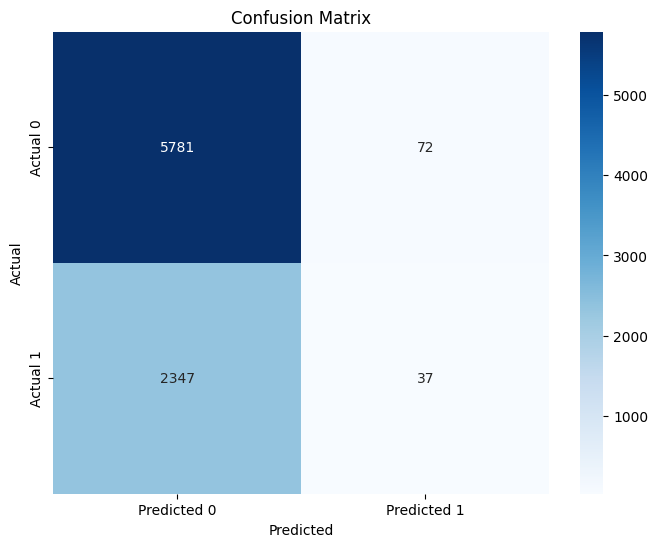

In [408]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

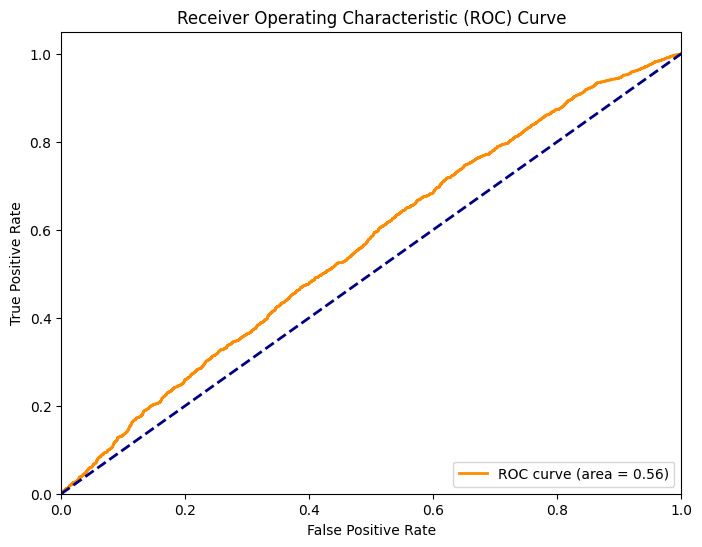

In [409]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

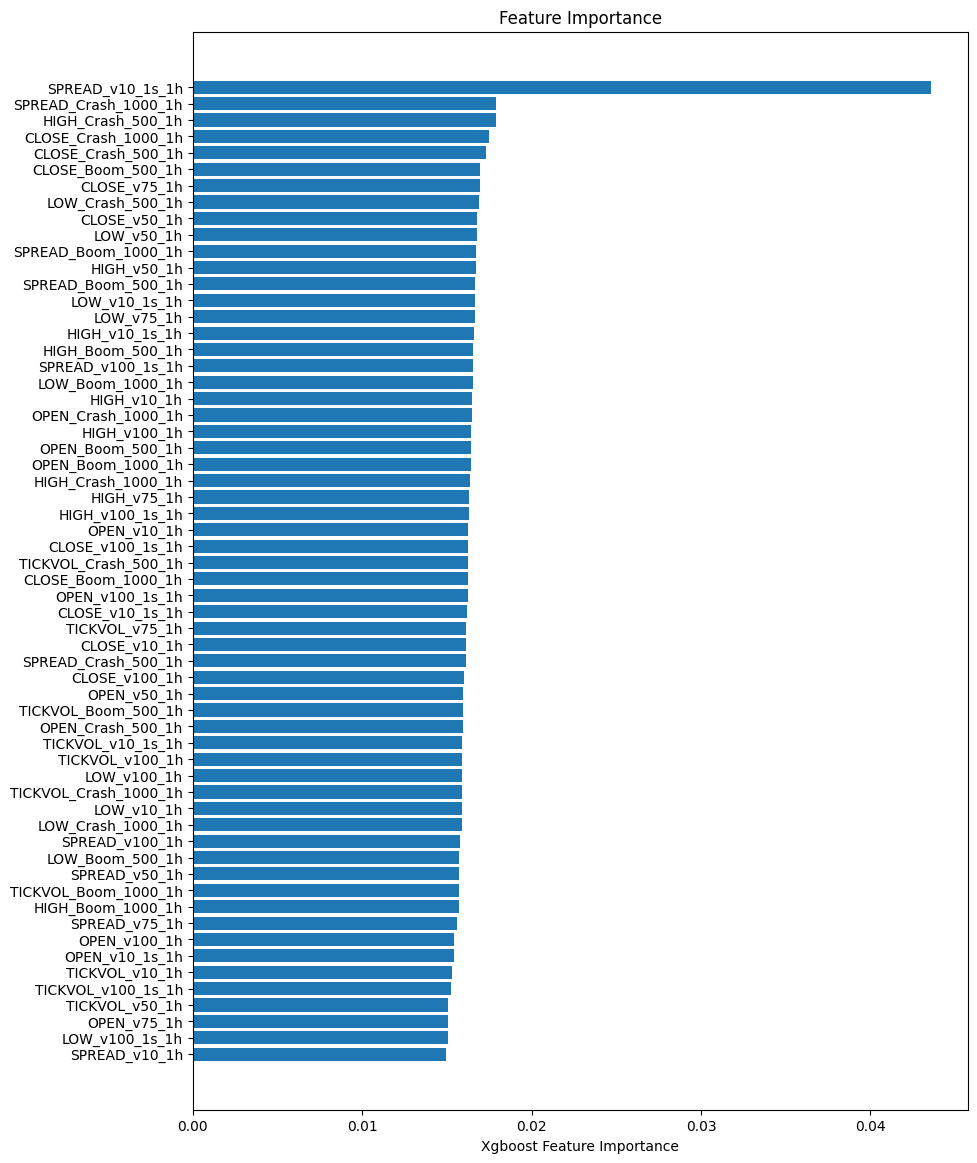

In [410]:
# Plot feature importance
plt.figure(figsize=(10, 14))
feature_importances = model.feature_importances_
sorted_idx = feature_importances.argsort()
plt.barh(X_cols.columns[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.title("Feature Importance")
plt.show()

#### *KNN*

In [411]:
# Initialize the k-NN model
knn = KNeighborsClassifier(n_neighbors=25) 

# Train the model
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)
y_proba = knn.predict_proba(X_test)[:, 1]

In [412]:
# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 70.44%


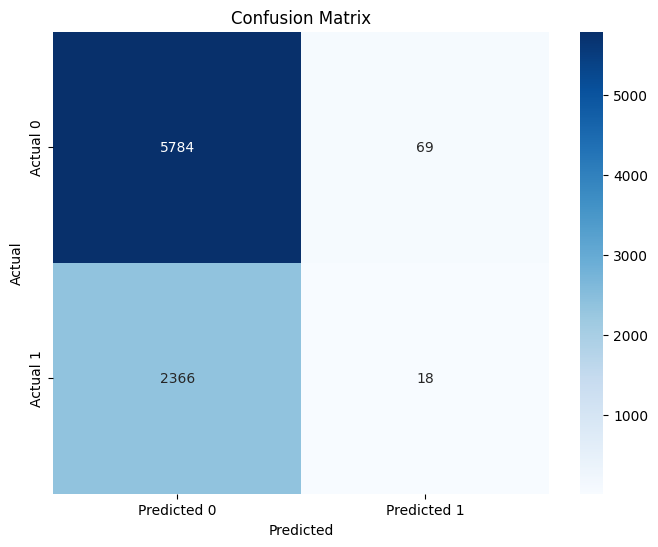

In [413]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

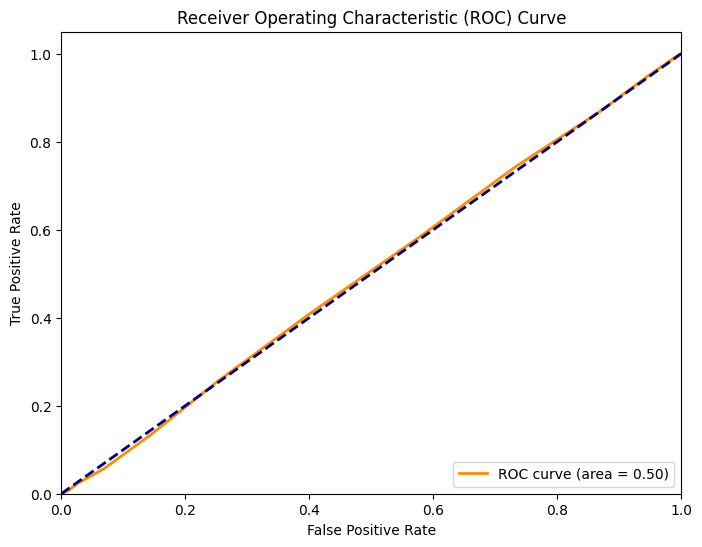

In [414]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Standard Scaling

#### *XGBoost*

In [415]:
y = dff['c500d'].values

In [416]:
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = XGBClassifier(device='gpu', eta=0.1, max_depth=60, sampling_method='gradient_based', use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=60,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [417]:
# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # For ROC curve
# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 73.81%


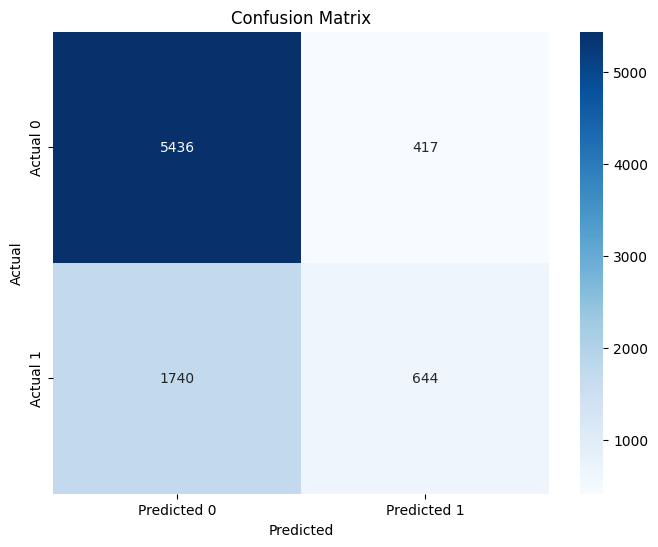

In [418]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

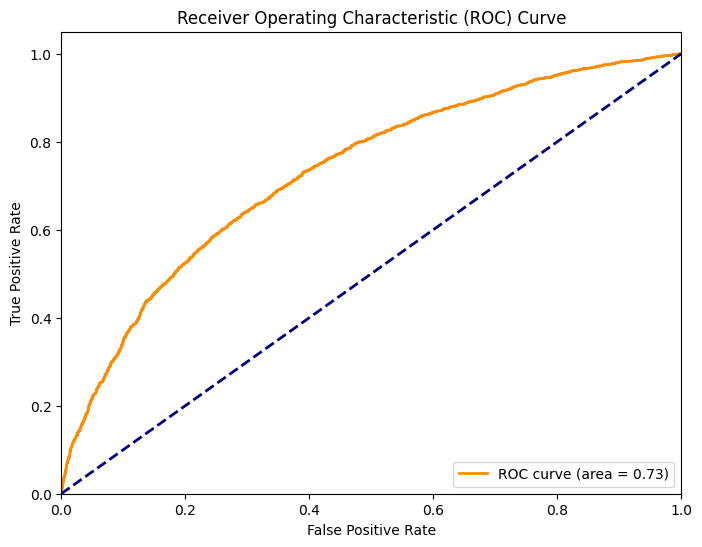

In [419]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

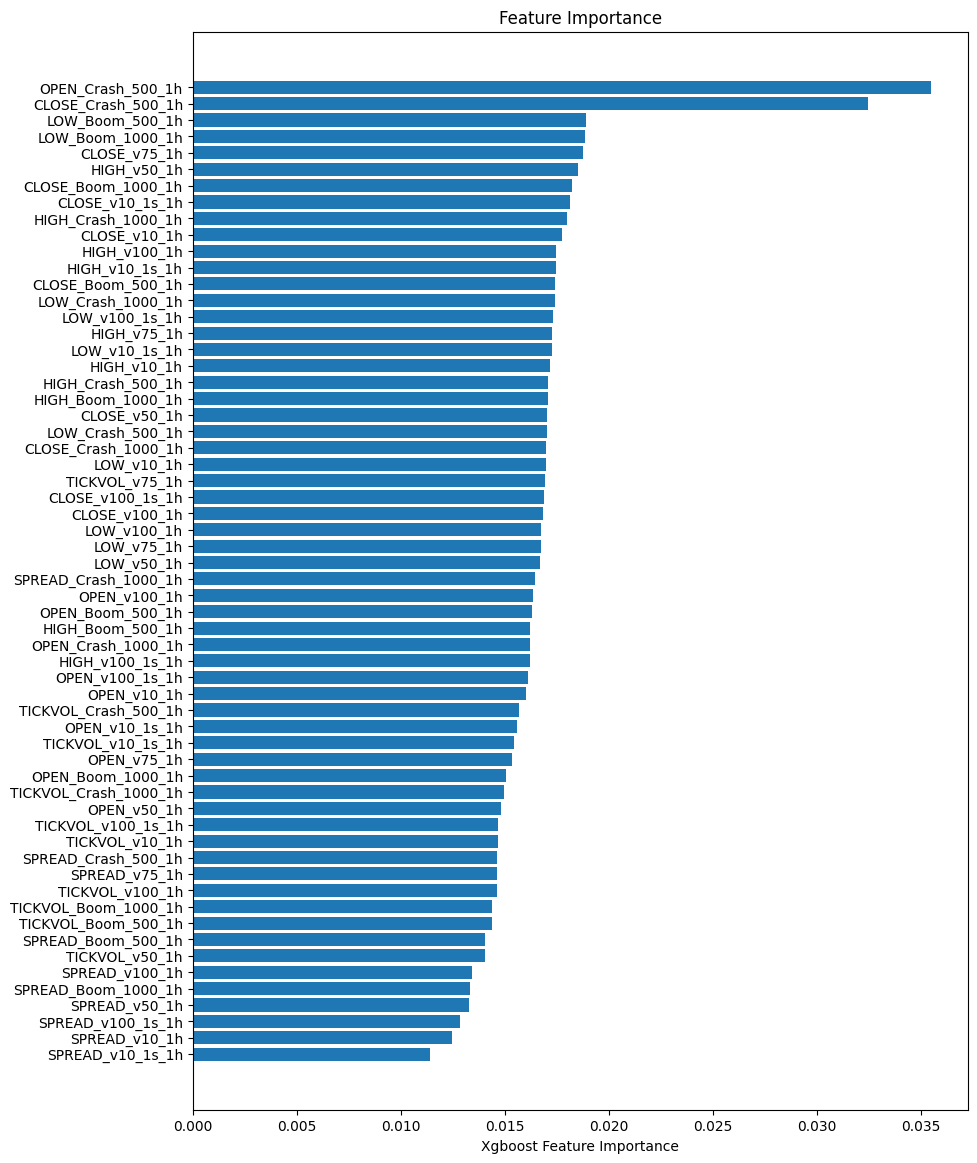

In [420]:
# Plot feature importance
plt.figure(figsize=(10, 14))
feature_importances = model.feature_importances_
sorted_idx = feature_importances.argsort()
plt.barh(X_cols.columns[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.title("Feature Importance")
plt.show()

#### *KNN*

In [421]:
# Initialize the k-NN model
knn = KNeighborsClassifier(n_neighbors=25) 

# Train the model
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)
y_proba = knn.predict_proba(X_test)[:, 1]

In [422]:
# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 69.93%


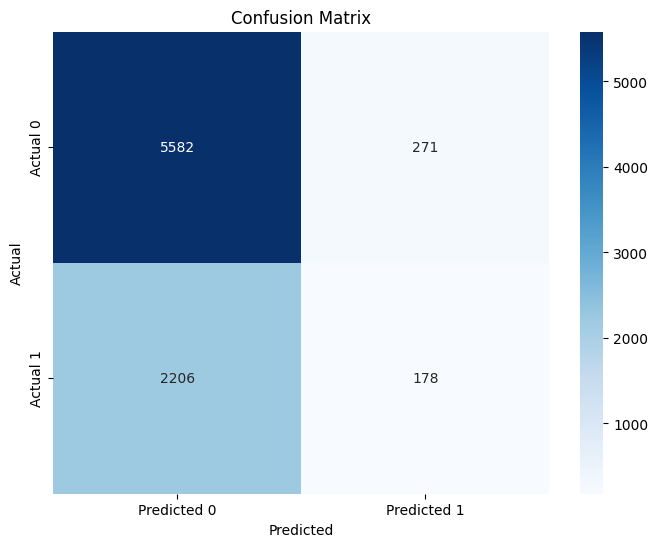

In [423]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

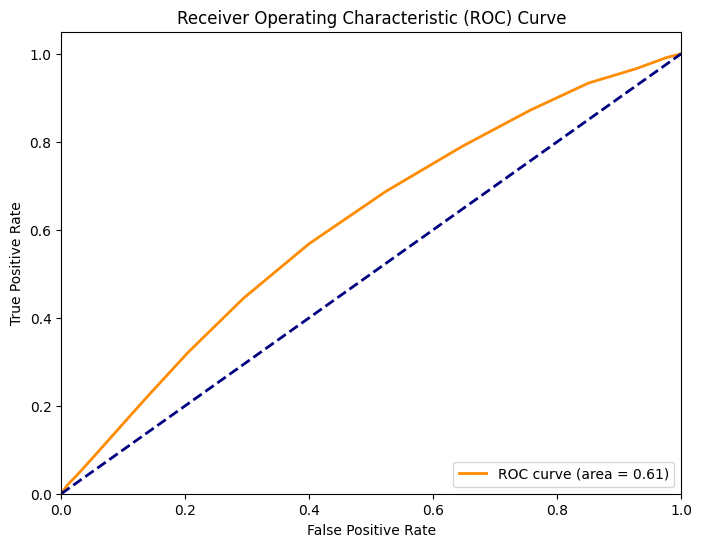

In [424]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Crash 1000

### RAW values

#### *XGBoost*

In [425]:
y = dff['c1000d'].values

In [426]:
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42)

In [427]:
model = XGBClassifier(device='gpu', eta=0.1, max_depth=50, sampling_method='gradient_based', use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=50,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [428]:
# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # For ROC curve

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 75.53%


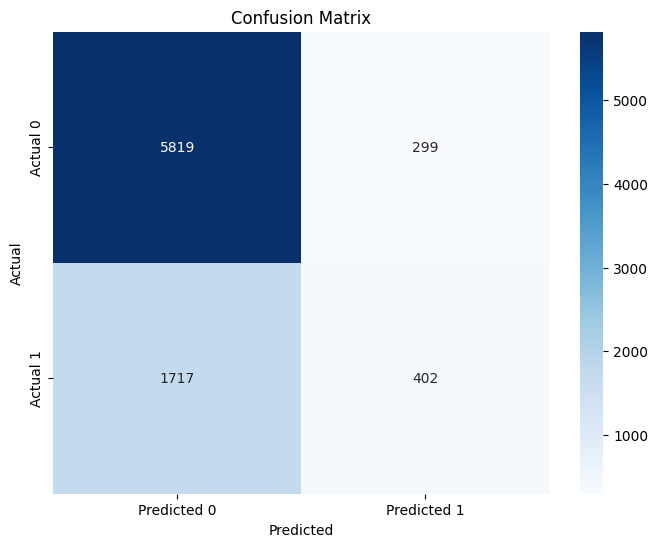

In [429]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

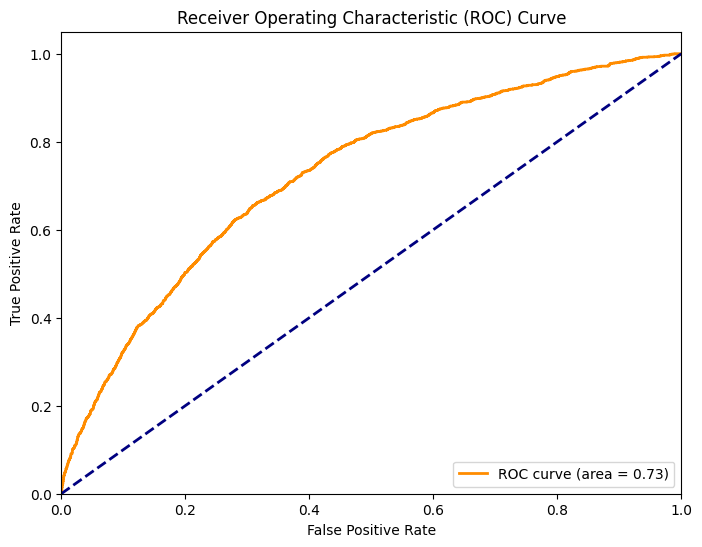

In [430]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

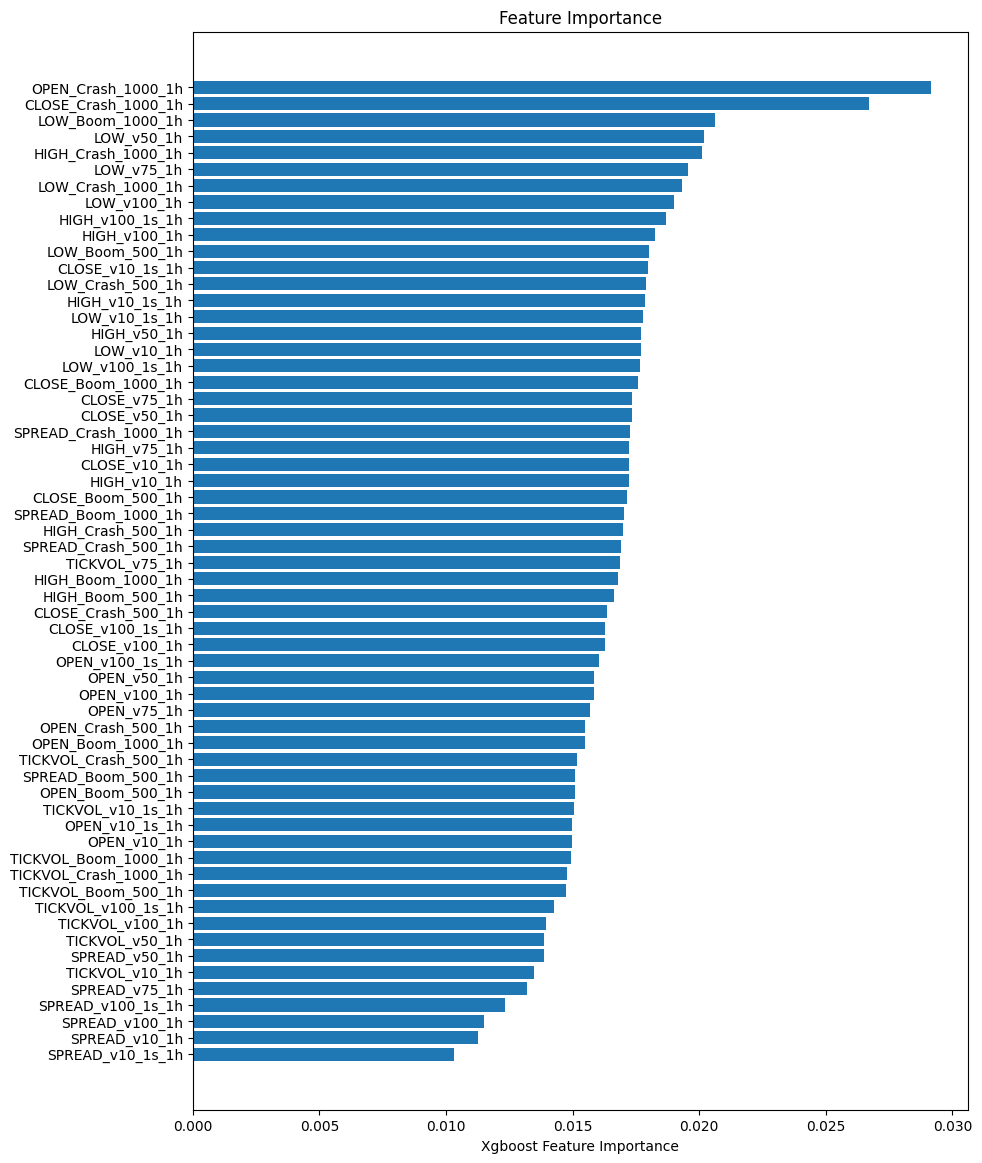

In [431]:
# Plot feature importance
plt.figure(figsize=(10, 14))
feature_importances = model.feature_importances_
sorted_idx = feature_importances.argsort()
plt.barh(X_cols.columns[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.title("Feature Importance")
plt.show()

#### *KNN*

In [432]:
# Initialize the k-NN model
knn = KNeighborsClassifier(n_neighbors=10) 

# Train the model
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)
y_proba = knn.predict_proba(X_test)[:, 1]

In [433]:
# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 73.10%


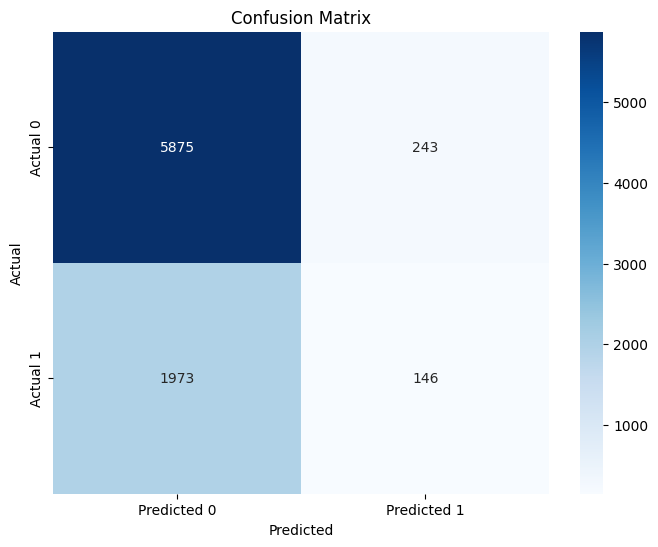

In [434]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

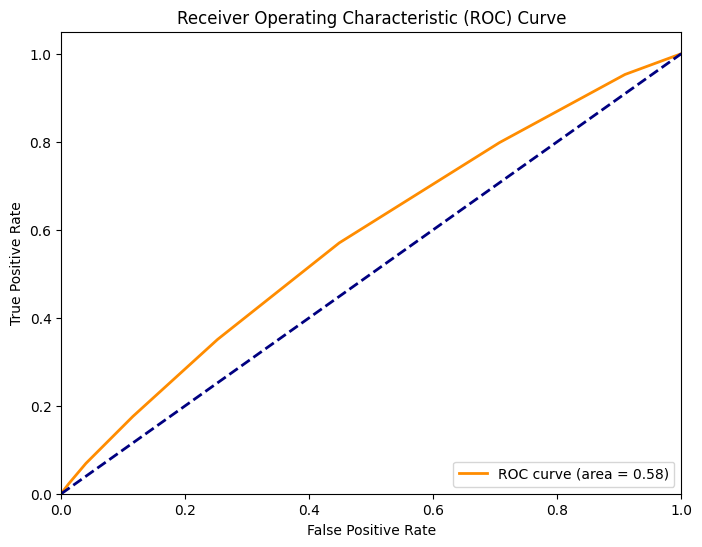

In [435]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Log Values

#### *XGBoost*

In [436]:
y = dff['c1000d'].values


In [437]:
X_train, X_test, y_train, y_test = train_test_split(X_log, y, test_size=0.2, random_state=42)

model = XGBClassifier(device='gpu', eta=0.1, max_depth=60, sampling_method='gradient_based', use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=60,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [438]:
# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # For ROC curve
# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 75.76%


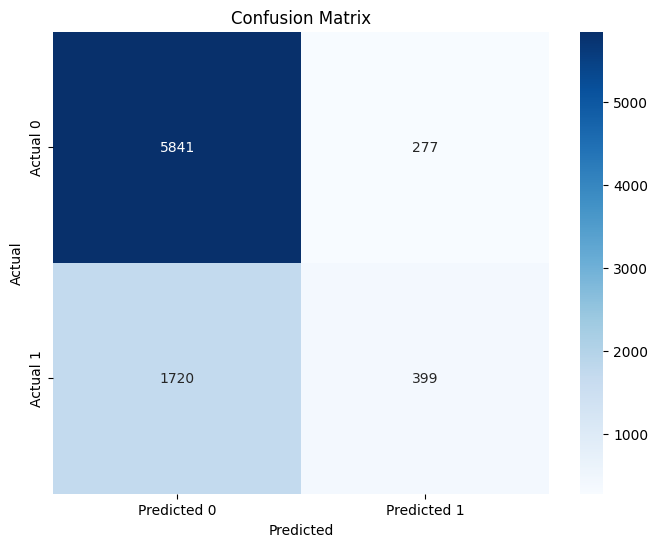

In [439]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


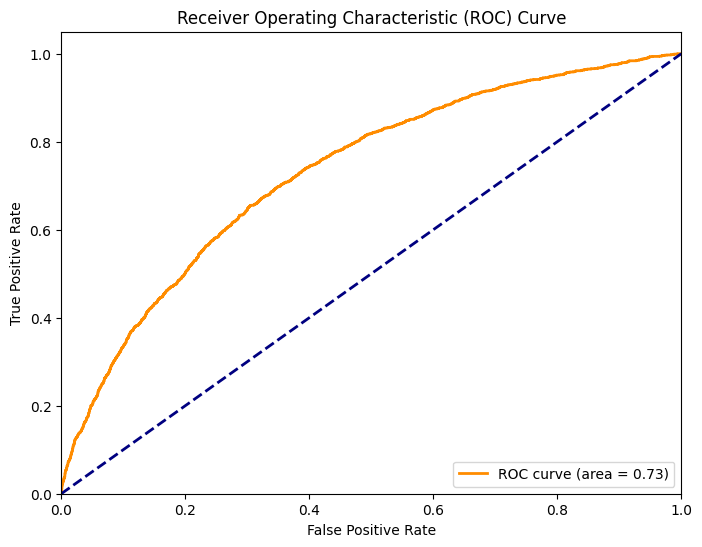

In [440]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

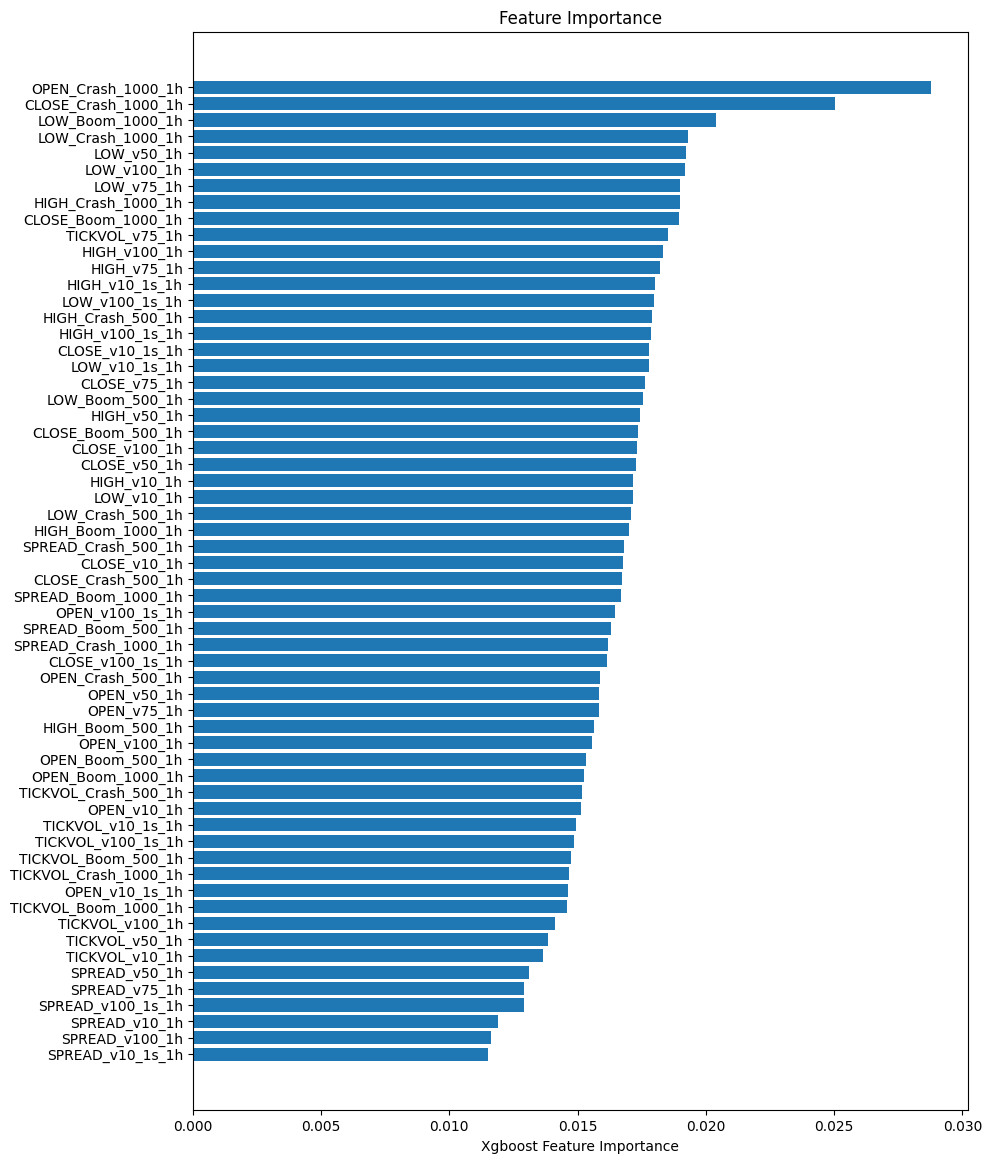

In [441]:
# Plot feature importance
plt.figure(figsize=(10, 14))
feature_importances = model.feature_importances_
sorted_idx = feature_importances.argsort()
plt.barh(X_cols.columns[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.title("Feature Importance")
plt.show()

#### *KNN*

In [442]:
# Initialize the k-NN model
knn = KNeighborsClassifier(n_neighbors=10) 

# Train the model
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)
y_proba = knn.predict_proba(X_test)[:, 1]

In [443]:
# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 74.36%


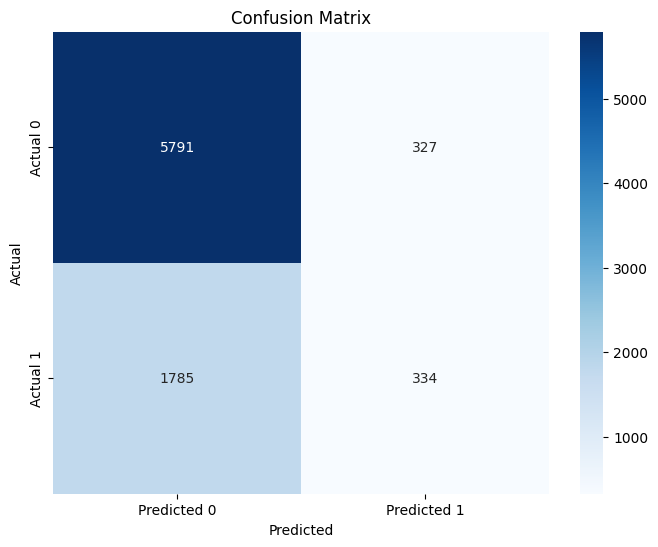

In [444]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

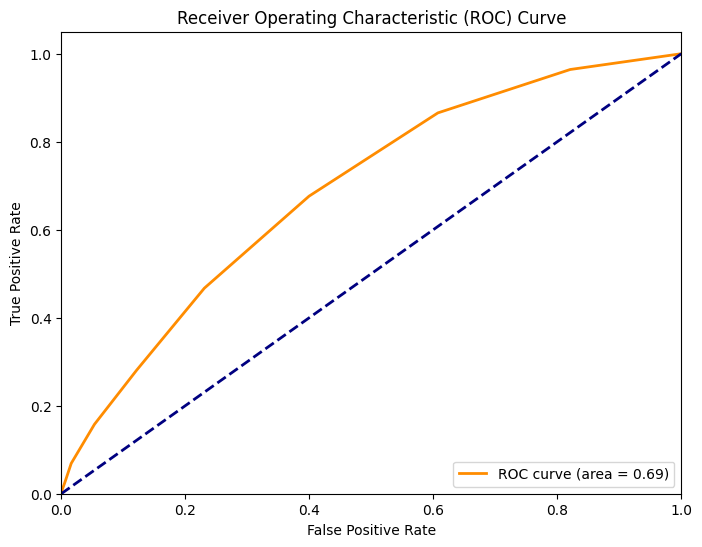

In [445]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Sin Values

#### *XGBoost*

In [446]:

y = dff['c1000d'].values


In [447]:
X_train, X_test, y_train, y_test = train_test_split(X_sin, y, test_size=0.2, random_state=42)

model = XGBClassifier(device='gpu', eta=0.1, max_depth=60, sampling_method='gradient_based', use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=60,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [448]:
# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # For ROC curve
# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 74.15%


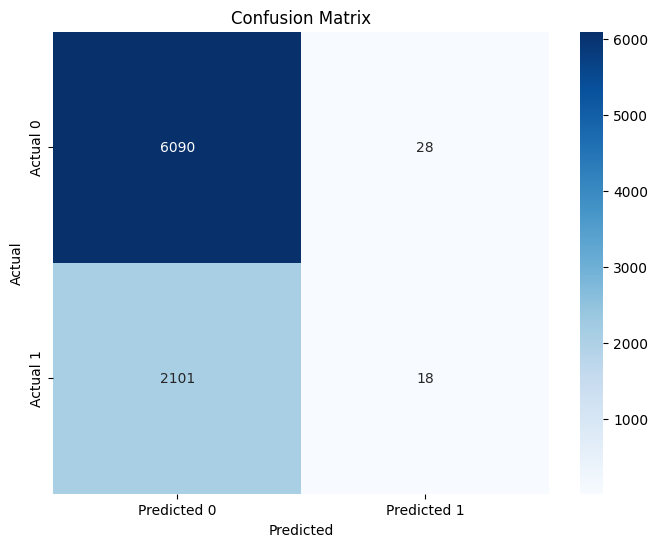

In [449]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

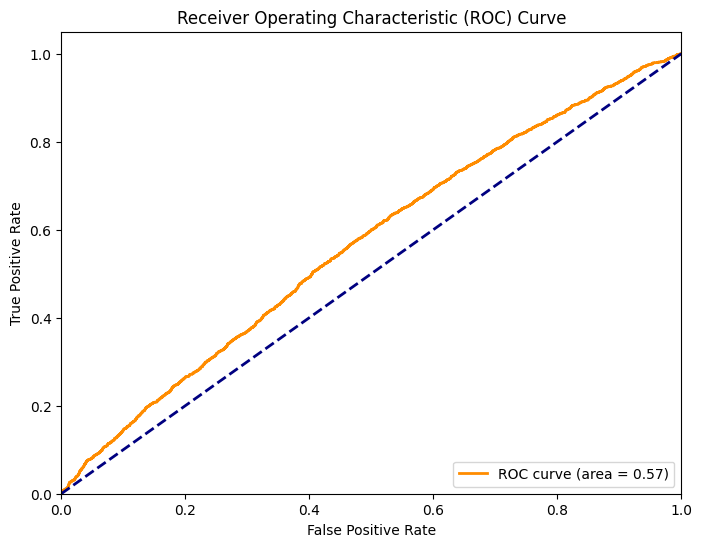

In [450]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

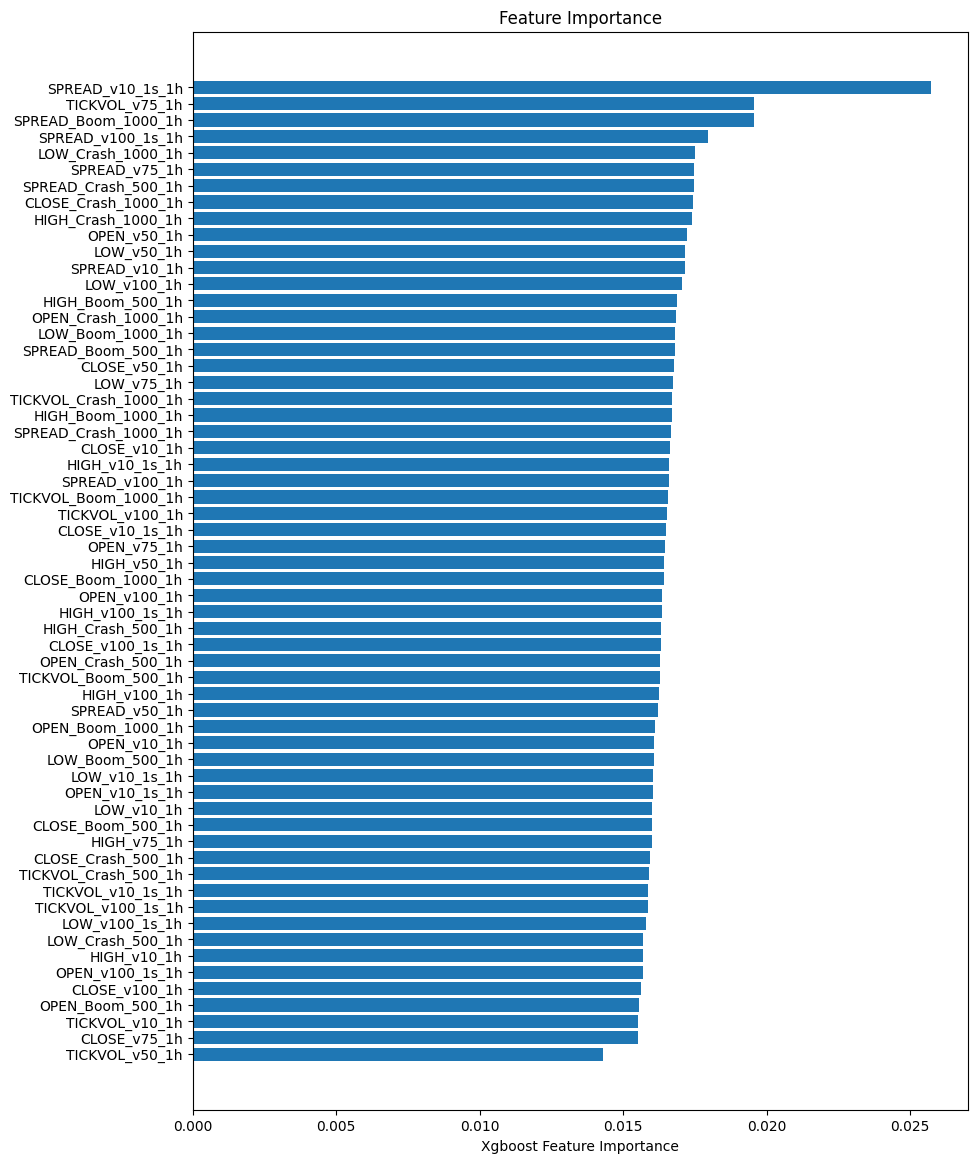

In [451]:
# Plot feature importance
plt.figure(figsize=(10, 14))
feature_importances = model.feature_importances_
sorted_idx = feature_importances.argsort()
plt.barh(X_cols.columns[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.title("Feature Importance")
plt.show()

#### *KNN*

In [452]:
# Initialize the k-NN model
knn = KNeighborsClassifier(n_neighbors=10) 

# Train the model
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)
y_proba = knn.predict_proba(X_test)[:, 1]

In [453]:
# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 73.47%


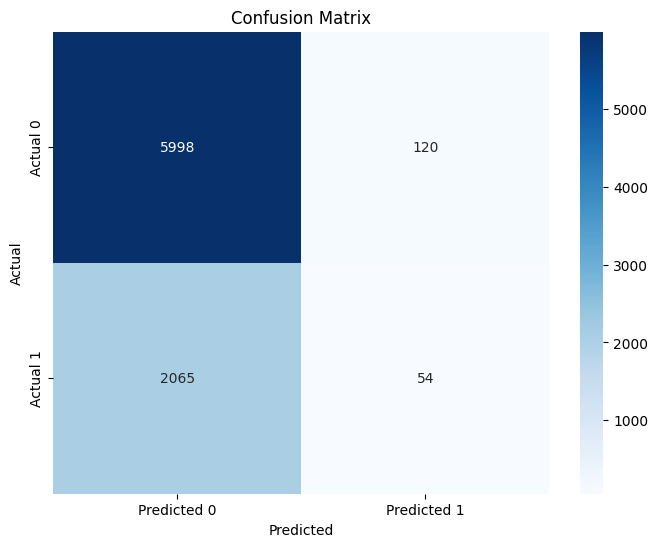

In [454]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

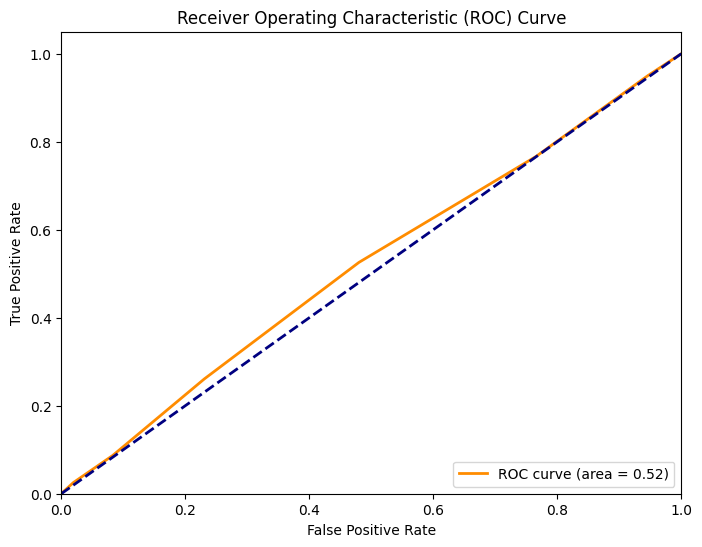

In [455]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Standard Scaler

#### *XGBoost*

In [456]:

y = dff['c1000d'].values


In [457]:
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = XGBClassifier(device='gpu', eta=0.1, max_depth=60, sampling_method='gradient_based', use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=60,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [458]:
# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # For ROC curve
# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 75.83%


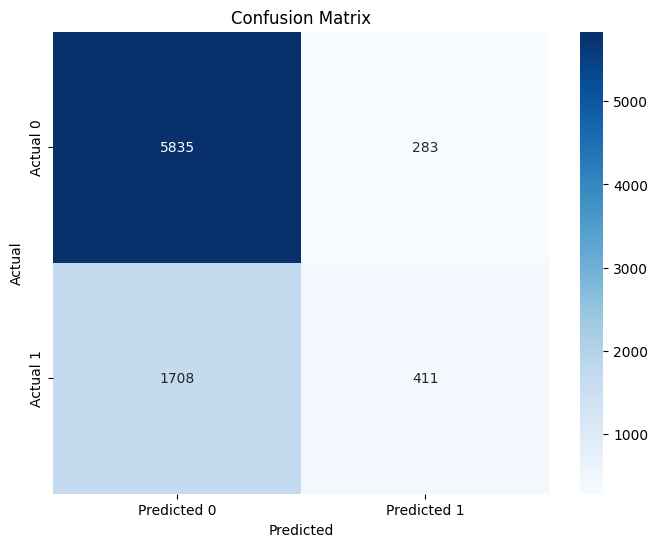

In [459]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

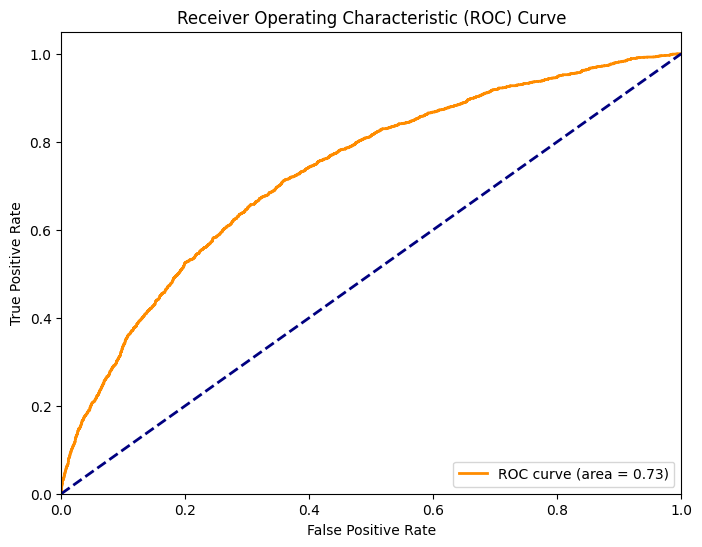

In [460]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

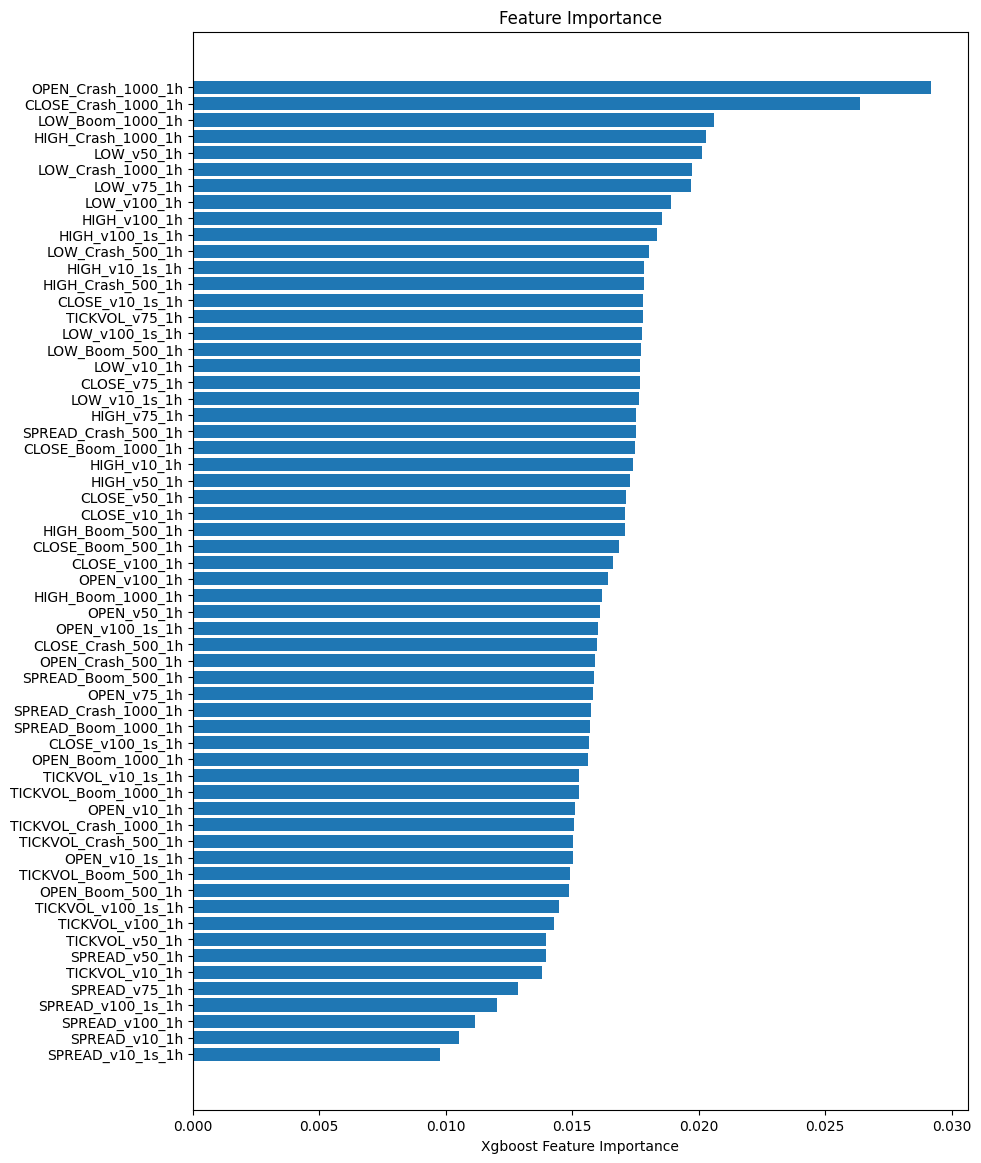

In [461]:
# Plot feature importance
plt.figure(figsize=(10, 14))
feature_importances = model.feature_importances_
sorted_idx = feature_importances.argsort()
plt.barh(X_cols.columns[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.title("Feature Importance")
plt.show()

#### *KNN*

In [462]:
# Initialize the k-NN model
knn = KNeighborsClassifier(n_neighbors=10) 

# Train the model
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)
y_proba = knn.predict_proba(X_test)[:, 1]


In [463]:
# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 73.25%


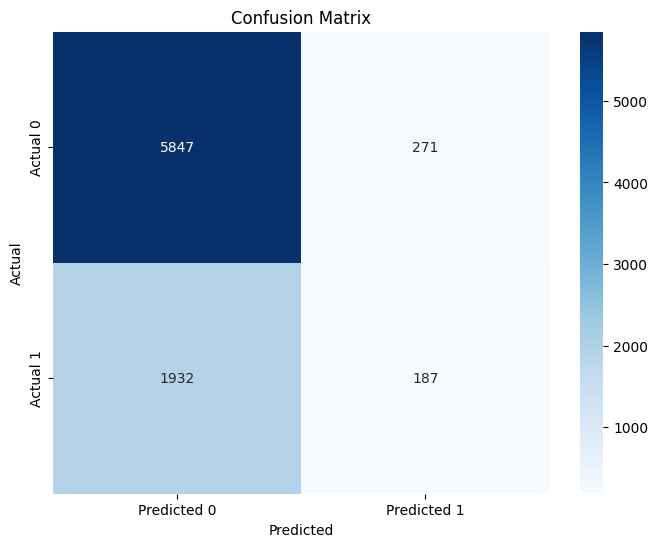

In [464]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

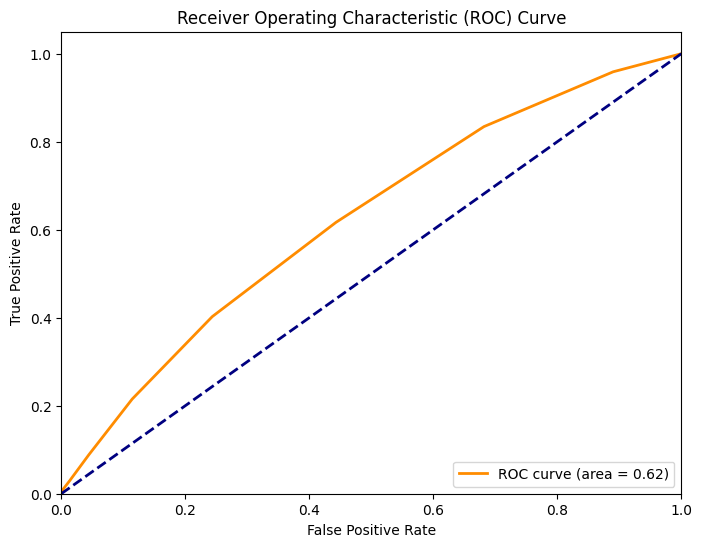

In [465]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Results

In [ ]:
#boom500 raw values
# XGBoost accuracy =  , roc =
# KNN accuracy =  , roc =

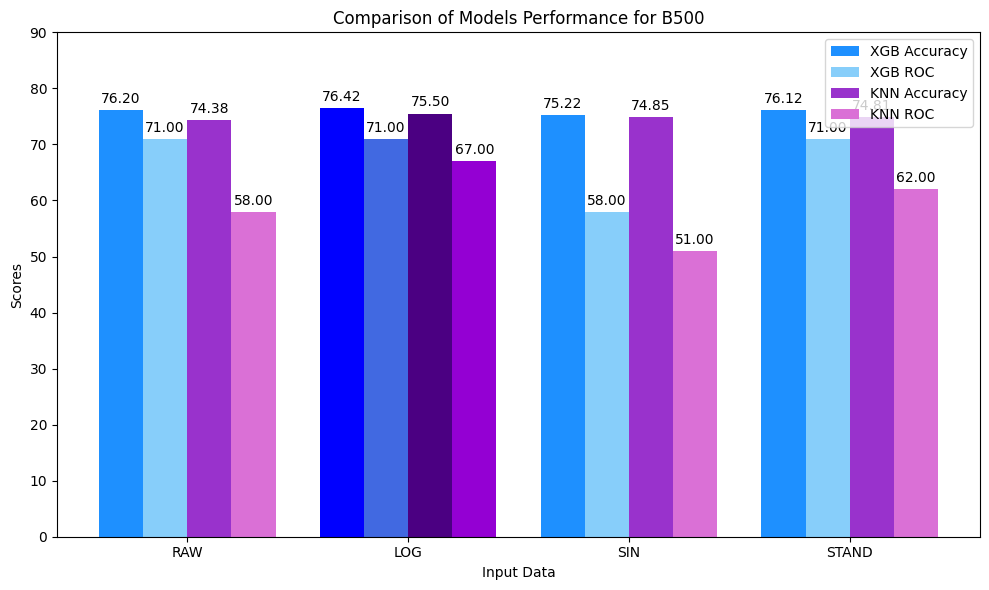

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the image
methods = ['RAW', 'LOG', 'SIN', 'STAND']
xgb_accuracy = [76.20, 76.42, 75.22, 76.12]
xgb_roc = [71, 71, 58, 71]
knn_accuracy = [74.38, 75.50, 74.85, 74.81]
knn_roc = [58, 67, 51, 62]

# Plotting the bar chart
x = np.arange(len(methods))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
#rects1 = ax.bar(x - width*1.5, xgb_accuracy, width, label='XGB Accuracy', color = 'blue')
#rects2 = ax.bar(x - width/2, xgb_roc, width, label='XGB ROC', color = 'royalblue')
#rects3 = ax.bar(x + width/2, knn_accuracy, width, label='KNN Accuracy', color = 'indigo')
#rects4 = ax.bar(x + width*1.5, knn_roc, width, label='KNN ROC', color = 'darkviolet')


xgb_accuracy_colors = ['dodgerblue', 'blue', 'dodgerblue', 'dodgerblue']
xgb_roc_colors = ['lightskyblue', 'royalblue', 'lightskyblue', 'lightskyblue']
knn_accuracy_colors = ['darkorchid', 'indigo', 'darkorchid', 'darkorchid']
knn_roc_colors = ['orchid', 'darkviolet', 'orchid', 'orchid']

rects1 = ax.bar(x - width*1.5, xgb_accuracy, width, label='XGB Accuracy', color=xgb_accuracy_colors)
rects2 = ax.bar(x - width/2, xgb_roc, width, label='XGB ROC', color=xgb_roc_colors)
rects3 = ax.bar(x + width/2, knn_accuracy, width, label='KNN Accuracy', color=knn_accuracy_colors)
rects4 = ax.bar(x + width*1.5, knn_roc, width, label='KNN ROC', color=knn_roc_colors)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Input Data')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Models Performance for B500')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.set_ylim([0,90])
ax.legend()

# Function to add labels on the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)
add_labels(rects4)

fig.tight_layout()

plt.show()


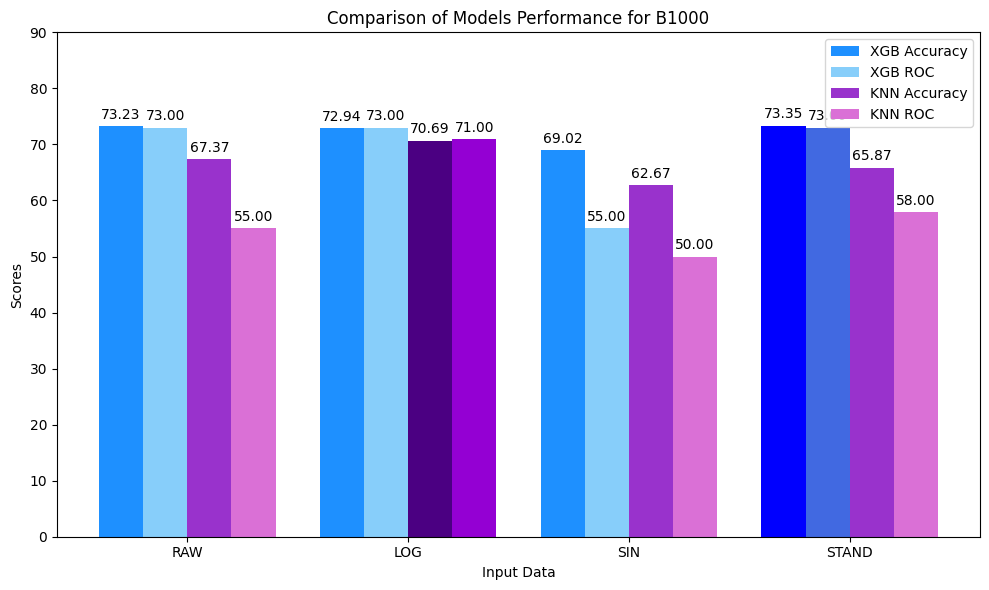

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the image
methods = ['RAW', 'LOG', 'SIN', 'STAND']
xgb_accuracy = [73.23, 72.94, 69.02, 73.35]
xgb_roc = [73, 73, 55, 73]
knn_accuracy = [67.37, 70.69, 62.67, 65.87]
knn_roc = [55, 71, 50, 58]

# Plotting the bar chart
x = np.arange(len(methods))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

xgb_accuracy_colors = ['dodgerblue', 'dodgerblue', 'dodgerblue', 'blue']
xgb_roc_colors = ['lightskyblue', 'lightskyblue', 'lightskyblue', 'royalblue']
knn_accuracy_colors = ['darkorchid', 'indigo', 'darkorchid', 'darkorchid']
knn_roc_colors = ['orchid', 'darkviolet', 'orchid', 'orchid']

rects1 = ax.bar(x - width*1.5, xgb_accuracy, width, label='XGB Accuracy', color=xgb_accuracy_colors)
rects2 = ax.bar(x - width/2, xgb_roc, width, label='XGB ROC', color=xgb_roc_colors)
rects3 = ax.bar(x + width/2, knn_accuracy, width, label='KNN Accuracy', color=knn_accuracy_colors)
rects4 = ax.bar(x + width*1.5, knn_roc, width, label='KNN ROC', color=knn_roc_colors)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Input Data')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Models Performance for B1000')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.set_ylim([0,90])
ax.legend()

# Function to add labels on the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)
add_labels(rects4)

fig.tight_layout()

plt.show()


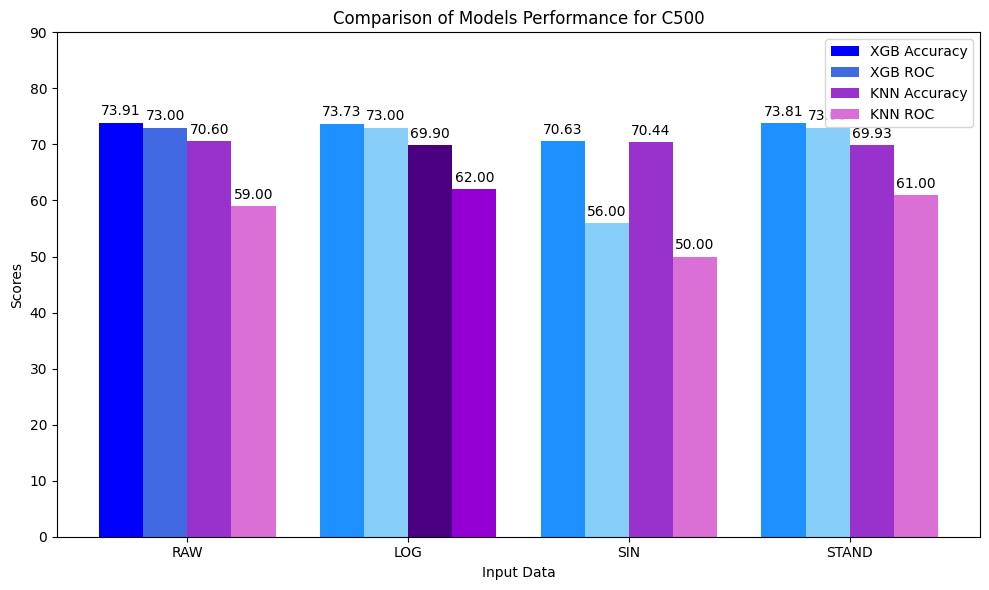

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the image
methods = ['RAW', 'LOG', 'SIN', 'STAND']
xgb_accuracy = [73.91, 73.73, 70.63, 73.81]
xgb_roc = [73, 73, 56, 73]
knn_accuracy = [70.60, 69.90, 70.44, 69.93]
knn_roc = [59, 62, 50, 61]

# Plotting the bar chart
x = np.arange(len(methods))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

xgb_accuracy_colors = ['blue','dodgerblue', 'dodgerblue', 'dodgerblue']
xgb_roc_colors = ['royalblue', 'lightskyblue', 'lightskyblue', 'lightskyblue']
knn_accuracy_colors = ['darkorchid', 'indigo', 'darkorchid', 'darkorchid']
knn_roc_colors = ['orchid', 'darkviolet', 'orchid', 'orchid']

rects1 = ax.bar(x - width*1.5, xgb_accuracy, width, label='XGB Accuracy', color=xgb_accuracy_colors)
rects2 = ax.bar(x - width/2, xgb_roc, width, label='XGB ROC', color=xgb_roc_colors)
rects3 = ax.bar(x + width/2, knn_accuracy, width, label='KNN Accuracy', color=knn_accuracy_colors)
rects4 = ax.bar(x + width*1.5, knn_roc, width, label='KNN ROC', color=knn_roc_colors)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Input Data')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Models Performance for C500')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.set_ylim([0,90])
ax.legend()

# Function to add labels on the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)
add_labels(rects4)

fig.tight_layout()

plt.show()


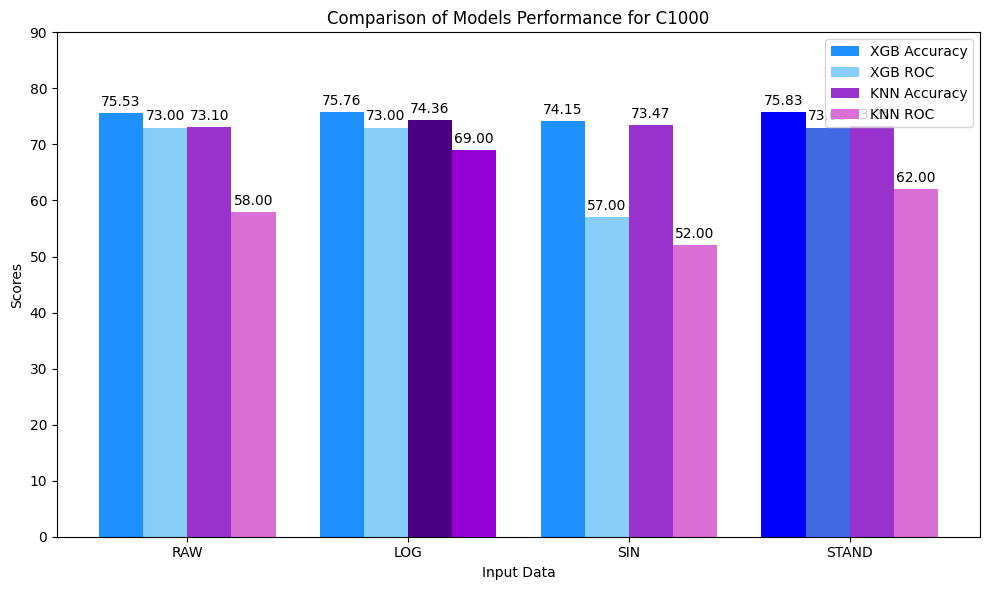

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the image
methods = ['RAW', 'LOG', 'SIN', 'STAND']
xgb_accuracy = [75.53, 75.76, 74.15, 75.83]
xgb_roc = [73, 73, 57, 73]
knn_accuracy = [73.10, 74.36, 73.47, 73.25]
knn_roc = [58, 69, 52, 62]

# Plotting the bar chart
x = np.arange(len(methods))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

xgb_accuracy_colors = ['dodgerblue', 'dodgerblue', 'dodgerblue','blue']
xgb_roc_colors = ['lightskyblue', 'lightskyblue', 'lightskyblue','royalblue']
knn_accuracy_colors = ['darkorchid', 'indigo', 'darkorchid', 'darkorchid']
knn_roc_colors = ['orchid', 'darkviolet', 'orchid', 'orchid']

rects1 = ax.bar(x - width*1.5, xgb_accuracy, width, label='XGB Accuracy', color=xgb_accuracy_colors)
rects2 = ax.bar(x - width/2, xgb_roc, width, label='XGB ROC', color=xgb_roc_colors)
rects3 = ax.bar(x + width/2, knn_accuracy, width, label='KNN Accuracy', color=knn_accuracy_colors)
rects4 = ax.bar(x + width*1.5, knn_roc, width, label='KNN ROC', color=knn_roc_colors)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Input Data')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Models Performance for C1000')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.set_ylim([0,90])
ax.legend()

# Function to add labels on the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)
add_labels(rects4)

fig.tight_layout()

plt.show()
